In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.preprocessing import StandardScaler
from fancyimpute import MICE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
%matplotlib inline

In [89]:
df_train = pd.read_csv('data/churn_train.csv')

In [90]:
def add_target_clean(df):
    active_date = date(2014,6,1)
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df['signup_date'] = pd.to_datetime(df['signup_date']) #after looking at this, we decided it wasn't relevant to churn so we dropped it
    df['active'] = (df['last_trip_date'] > active_date).astype(int)
    df['iPhone'] = (df['phone'] == 'iPhone').astype(int)
    df['luxury_car_user'] = df['luxury_car_user'].astype(int)
    df.drop(['signup_date', 'last_trip_date', 'phone'], axis = 1, inplace = True)
    return df

In [91]:
df_train = add_target_clean(df_train)

In [112]:
def plot_quantitative_violinplot(df):
    df_num_columns = df.select_dtypes(include=[np.number])
    df_boxplot_columns = [column for column in df_num_columns if column not in ['active', 'iPhone', 'luxury_car_user']]
    fig = plt.figure(figsize=(20,6))
    for ind, column in enumerate(df_boxplot_columns):
        ax = fig.add_subplot(1,len(df_boxplot_columns),ind+1)
        ax = sns.violinplot(x = df['active'], y = df[column], data = df)
        ax.yaxis.label.set_visible(False)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels[0] = 'No'
        labels[1] = 'Yes'
        ax.set_xticklabels(labels)
        ax.get_figure().gca().set_xlabel('Active', fontdict = {'fontsize': 10})
        ax.get_figure().gca().set_title(column, fontdict = {'fontsize': 10})
        plt.yticks(fontsize = 10, rotation='horizontal') #makes the ylabels horizontal
        plt.xticks(fontsize = 10, rotation='horizontal') #makes the xlabels vertical
        #plt.legend(fontsize = 10)
        #plt.tight_layout()
    #plt.title('Comparisons of Active and Inactive Users', fontsize = 20)
    plt.savefig('images/violin_plots_active_inactive.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

/Users/sarahlewis/ENTER/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/sarahlewis/ENTER/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


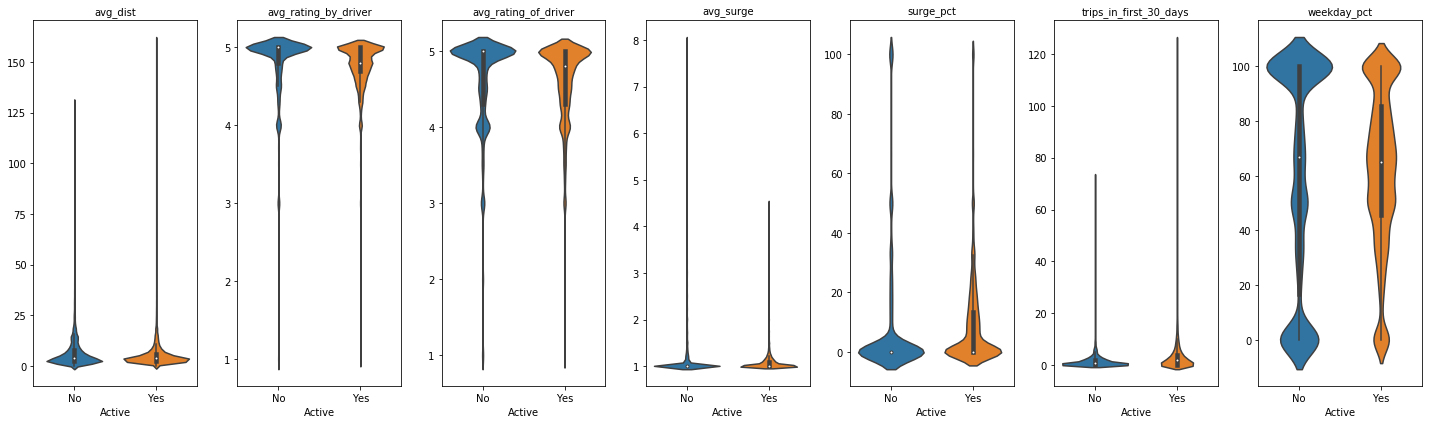

In [113]:
plot_quantitative_violinplot(df_train)

In [108]:
def plot_categorical_countplot(df, column):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(1,1,1)
    ax = sns.countplot(x = df[column], hue = df['active'], data = df)
    ax.yaxis.label.set_visible(False)
    #ax.xaxis.label.set_visible(False)
    ax.set_xlabel('Luxury Car User', fontdict = {'fontsize': 16})
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'No'
    labels[1] = 'Yes'
    ax.set_xticklabels(labels)
    
    plt.yticks(fontsize = 16, rotation='horizontal') #makes the ylabels horizontal
    plt.xticks(fontsize = 16, rotation='horizontal') #makes the xlabels vertical
    plt.legend(['inactive', 'active'], fontsize = 16)
    
    plt.title('Frequency of Active and Inactive Users Depending on Luxury Car Usage', fontsize = 20)
    plt.savefig('images/count_plots_luxury_car.png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

/Users/sarahlewis/ENTER/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


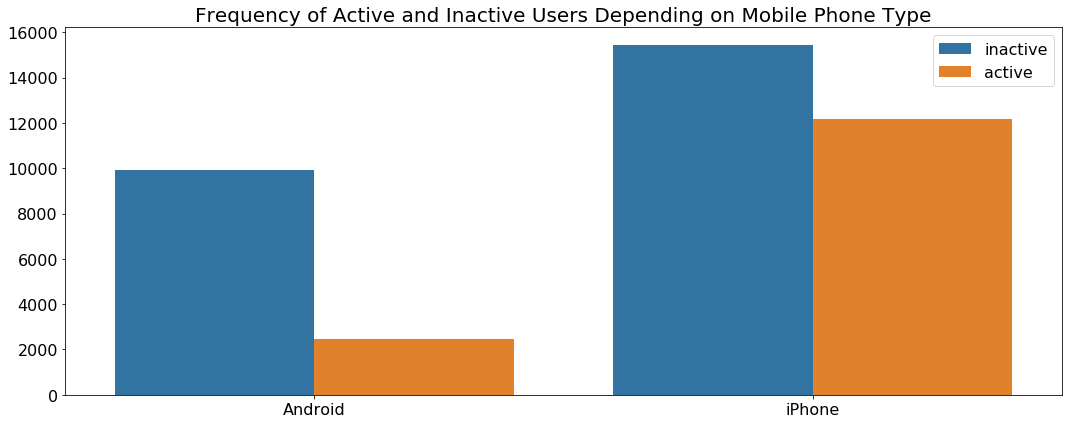

In [107]:
plot_categorical_countplot(df_train, 'iPhone')

/Users/sarahlewis/ENTER/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


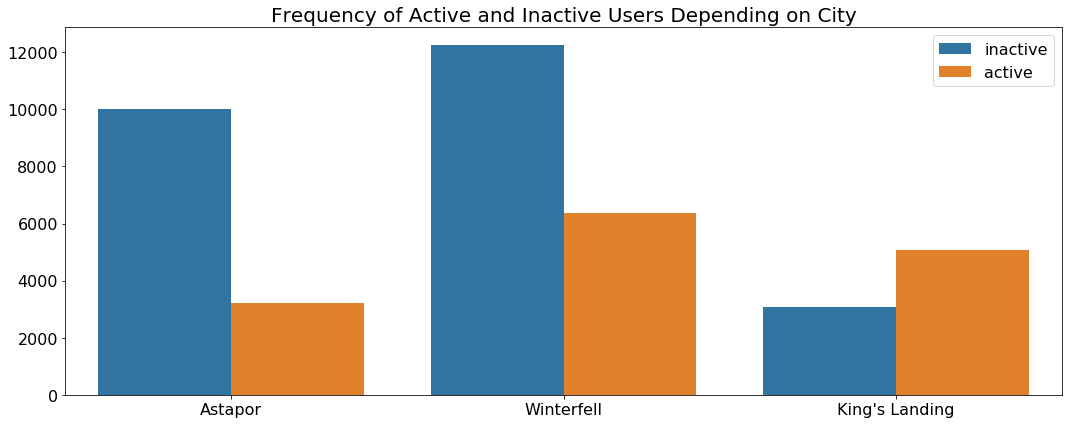

In [85]:
plot_categorical_countplot(df_train, 'city')

/Users/sarahlewis/ENTER/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


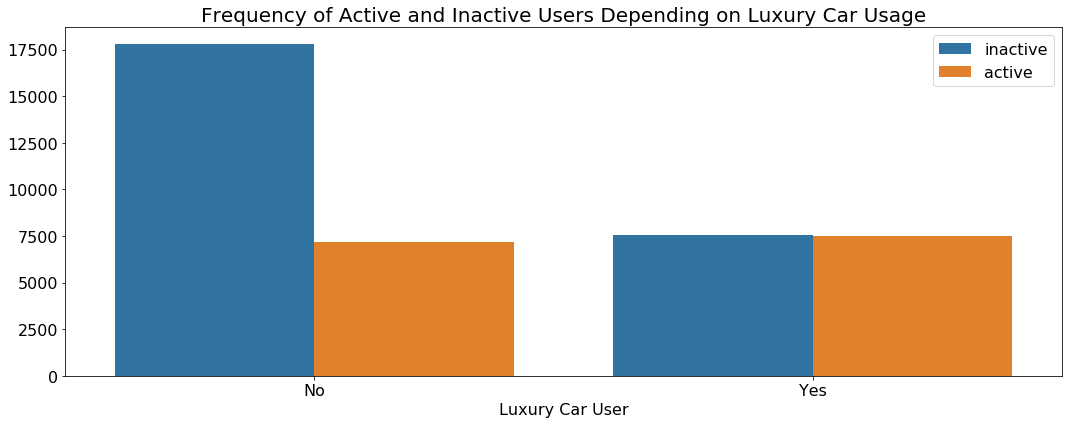

In [109]:
plot_categorical_countplot(df_train, 'luxury_car_user')

In [221]:
def clean_fill_nulls(df):
    active_date = date(2014,6,1)
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    #df['iPhone'] = (df['phone'] == 'iPhone').astype(int)
    df['luxury_car_user'] = df['luxury_car_user'].astype(int)
    df['active'] = (df['last_trip_date'] > active_date).astype(int)
    df.drop(['signup_date', 'last_trip_date'], axis = 1, inplace = True)
    df = pd.get_dummies(df, columns=['city', 'phone'])

    #y = df.pop('active').values
    array = df.values.astype(float)
    array_filled_mice = MICE(n_imputations=6700).complete(array)
    scaler = StandardScaler()
    array_filled_mice = scaler.fit_transform(array_filled_mice)
    columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
    'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user',
    'weekday_pct', 'active', 'city_Astapor', "city_King's Landing", 'city_Winterfell',
    'phone_Android', 'phone_iPhone']
    return pd.DataFrame(array_filled_mice, columns = columns)


In [235]:
df_train1 = pd.read_csv('data/churn_train.csv')

In [236]:
df_train1 = clean_fill_nulls(df_train1)

[MICE] Completing matrix with shape (40000, 14)
[MICE] Starting imputation round 1/6710, elapsed time 0.009
[MICE] Starting imputation round 2/6710, elapsed time 0.175
[MICE] Starting imputation round 3/6710, elapsed time 0.207
[MICE] Starting imputation round 4/6710, elapsed time 0.236
[MICE] Starting imputation round 5/6710, elapsed time 0.266
[MICE] Starting imputation round 6/6710, elapsed time 0.293
[MICE] Starting imputation round 7/6710, elapsed time 0.318
[MICE] Starting imputation round 8/6710, elapsed time 0.344
[MICE] Starting imputation round 9/6710, elapsed time 0.371
[MICE] Starting imputation round 10/6710, elapsed time 0.398
[MICE] Starting imputation round 11/6710, elapsed time 0.429
[MICE] Starting imputation round 12/6710, elapsed time 0.501
[MICE] Starting imputation round 13/6710, elapsed time 0.533
[MICE] Starting imputation round 14/6710, elapsed time 0.559
[MICE] Starting imputation round 15/6710, elapsed time 0.585
[MICE] Starting imputation round 16/6710, elap

[MICE] Starting imputation round 140/6710, elapsed time 4.339
[MICE] Starting imputation round 141/6710, elapsed time 4.369
[MICE] Starting imputation round 142/6710, elapsed time 4.401
[MICE] Starting imputation round 143/6710, elapsed time 4.429
[MICE] Starting imputation round 144/6710, elapsed time 4.459
[MICE] Starting imputation round 145/6710, elapsed time 4.496
[MICE] Starting imputation round 146/6710, elapsed time 4.524
[MICE] Starting imputation round 147/6710, elapsed time 4.551
[MICE] Starting imputation round 148/6710, elapsed time 4.579
[MICE] Starting imputation round 149/6710, elapsed time 4.609
[MICE] Starting imputation round 150/6710, elapsed time 4.637
[MICE] Starting imputation round 151/6710, elapsed time 4.664
[MICE] Starting imputation round 152/6710, elapsed time 4.693
[MICE] Starting imputation round 153/6710, elapsed time 4.724
[MICE] Starting imputation round 154/6710, elapsed time 4.755
[MICE] Starting imputation round 155/6710, elapsed time 4.808
[MICE] S

[MICE] Starting imputation round 273/6710, elapsed time 8.262
[MICE] Starting imputation round 274/6710, elapsed time 8.294
[MICE] Starting imputation round 275/6710, elapsed time 8.324
[MICE] Starting imputation round 276/6710, elapsed time 8.353
[MICE] Starting imputation round 277/6710, elapsed time 8.383
[MICE] Starting imputation round 278/6710, elapsed time 8.411
[MICE] Starting imputation round 279/6710, elapsed time 8.439
[MICE] Starting imputation round 280/6710, elapsed time 8.469
[MICE] Starting imputation round 281/6710, elapsed time 8.499
[MICE] Starting imputation round 282/6710, elapsed time 8.528
[MICE] Starting imputation round 283/6710, elapsed time 8.554
[MICE] Starting imputation round 284/6710, elapsed time 8.585
[MICE] Starting imputation round 285/6710, elapsed time 8.612
[MICE] Starting imputation round 286/6710, elapsed time 8.638
[MICE] Starting imputation round 287/6710, elapsed time 8.669
[MICE] Starting imputation round 288/6710, elapsed time 8.701
[MICE] S

[MICE] Starting imputation round 411/6710, elapsed time 12.235
[MICE] Starting imputation round 412/6710, elapsed time 12.266
[MICE] Starting imputation round 413/6710, elapsed time 12.295
[MICE] Starting imputation round 414/6710, elapsed time 12.322
[MICE] Starting imputation round 415/6710, elapsed time 12.349
[MICE] Starting imputation round 416/6710, elapsed time 12.379
[MICE] Starting imputation round 417/6710, elapsed time 12.406
[MICE] Starting imputation round 418/6710, elapsed time 12.433
[MICE] Starting imputation round 419/6710, elapsed time 12.461
[MICE] Starting imputation round 420/6710, elapsed time 12.490
[MICE] Starting imputation round 421/6710, elapsed time 12.518
[MICE] Starting imputation round 422/6710, elapsed time 12.548
[MICE] Starting imputation round 423/6710, elapsed time 12.576
[MICE] Starting imputation round 424/6710, elapsed time 12.602
[MICE] Starting imputation round 425/6710, elapsed time 12.631
[MICE] Starting imputation round 426/6710, elapsed time

[MICE] Starting imputation round 548/6710, elapsed time 16.212
[MICE] Starting imputation round 549/6710, elapsed time 16.241
[MICE] Starting imputation round 550/6710, elapsed time 16.268
[MICE] Starting imputation round 551/6710, elapsed time 16.299
[MICE] Starting imputation round 552/6710, elapsed time 16.325
[MICE] Starting imputation round 553/6710, elapsed time 16.352
[MICE] Starting imputation round 554/6710, elapsed time 16.383
[MICE] Starting imputation round 555/6710, elapsed time 16.410
[MICE] Starting imputation round 556/6710, elapsed time 16.440
[MICE] Starting imputation round 557/6710, elapsed time 16.471
[MICE] Starting imputation round 558/6710, elapsed time 16.497
[MICE] Starting imputation round 559/6710, elapsed time 16.525
[MICE] Starting imputation round 560/6710, elapsed time 16.552
[MICE] Starting imputation round 561/6710, elapsed time 16.580
[MICE] Starting imputation round 562/6710, elapsed time 16.607
[MICE] Starting imputation round 563/6710, elapsed time

[MICE] Starting imputation round 683/6710, elapsed time 20.122
[MICE] Starting imputation round 684/6710, elapsed time 20.151
[MICE] Starting imputation round 685/6710, elapsed time 20.182
[MICE] Starting imputation round 686/6710, elapsed time 20.211
[MICE] Starting imputation round 687/6710, elapsed time 20.238
[MICE] Starting imputation round 688/6710, elapsed time 20.267
[MICE] Starting imputation round 689/6710, elapsed time 20.296
[MICE] Starting imputation round 690/6710, elapsed time 20.325
[MICE] Starting imputation round 691/6710, elapsed time 20.353
[MICE] Starting imputation round 692/6710, elapsed time 20.385
[MICE] Starting imputation round 693/6710, elapsed time 20.413
[MICE] Starting imputation round 694/6710, elapsed time 20.444
[MICE] Starting imputation round 695/6710, elapsed time 20.473
[MICE] Starting imputation round 696/6710, elapsed time 20.501
[MICE] Starting imputation round 697/6710, elapsed time 20.530
[MICE] Starting imputation round 698/6710, elapsed time

[MICE] Starting imputation round 818/6710, elapsed time 24.055
[MICE] Starting imputation round 819/6710, elapsed time 24.087
[MICE] Starting imputation round 820/6710, elapsed time 24.127
[MICE] Starting imputation round 821/6710, elapsed time 24.164
[MICE] Starting imputation round 822/6710, elapsed time 24.198
[MICE] Starting imputation round 823/6710, elapsed time 24.235
[MICE] Starting imputation round 824/6710, elapsed time 24.277
[MICE] Starting imputation round 825/6710, elapsed time 24.314
[MICE] Starting imputation round 826/6710, elapsed time 24.341
[MICE] Starting imputation round 827/6710, elapsed time 24.371
[MICE] Starting imputation round 828/6710, elapsed time 24.401
[MICE] Starting imputation round 829/6710, elapsed time 24.432
[MICE] Starting imputation round 830/6710, elapsed time 24.461
[MICE] Starting imputation round 831/6710, elapsed time 24.491
[MICE] Starting imputation round 832/6710, elapsed time 24.523
[MICE] Starting imputation round 833/6710, elapsed time

[MICE] Starting imputation round 954/6710, elapsed time 27.977
[MICE] Starting imputation round 955/6710, elapsed time 28.005
[MICE] Starting imputation round 956/6710, elapsed time 28.031
[MICE] Starting imputation round 957/6710, elapsed time 28.061
[MICE] Starting imputation round 958/6710, elapsed time 28.088
[MICE] Starting imputation round 959/6710, elapsed time 28.119
[MICE] Starting imputation round 960/6710, elapsed time 28.148
[MICE] Starting imputation round 961/6710, elapsed time 28.176
[MICE] Starting imputation round 962/6710, elapsed time 28.204
[MICE] Starting imputation round 963/6710, elapsed time 28.235
[MICE] Starting imputation round 964/6710, elapsed time 28.265
[MICE] Starting imputation round 965/6710, elapsed time 28.294
[MICE] Starting imputation round 966/6710, elapsed time 28.323
[MICE] Starting imputation round 967/6710, elapsed time 28.353
[MICE] Starting imputation round 968/6710, elapsed time 28.381
[MICE] Starting imputation round 969/6710, elapsed time

[MICE] Starting imputation round 1086/6710, elapsed time 31.790
[MICE] Starting imputation round 1087/6710, elapsed time 31.819
[MICE] Starting imputation round 1088/6710, elapsed time 31.846
[MICE] Starting imputation round 1089/6710, elapsed time 31.875
[MICE] Starting imputation round 1090/6710, elapsed time 31.904
[MICE] Starting imputation round 1091/6710, elapsed time 31.933
[MICE] Starting imputation round 1092/6710, elapsed time 31.959
[MICE] Starting imputation round 1093/6710, elapsed time 31.988
[MICE] Starting imputation round 1094/6710, elapsed time 32.018
[MICE] Starting imputation round 1095/6710, elapsed time 32.048
[MICE] Starting imputation round 1096/6710, elapsed time 32.076
[MICE] Starting imputation round 1097/6710, elapsed time 32.103
[MICE] Starting imputation round 1098/6710, elapsed time 32.132
[MICE] Starting imputation round 1099/6710, elapsed time 32.163
[MICE] Starting imputation round 1100/6710, elapsed time 32.193
[MICE] Starting imputation round 1101/67

[MICE] Starting imputation round 1217/6710, elapsed time 35.569
[MICE] Starting imputation round 1218/6710, elapsed time 35.599
[MICE] Starting imputation round 1219/6710, elapsed time 35.626
[MICE] Starting imputation round 1220/6710, elapsed time 35.653
[MICE] Starting imputation round 1221/6710, elapsed time 35.682
[MICE] Starting imputation round 1222/6710, elapsed time 35.711
[MICE] Starting imputation round 1223/6710, elapsed time 35.738
[MICE] Starting imputation round 1224/6710, elapsed time 35.765
[MICE] Starting imputation round 1225/6710, elapsed time 35.790
[MICE] Starting imputation round 1226/6710, elapsed time 35.821
[MICE] Starting imputation round 1227/6710, elapsed time 35.852
[MICE] Starting imputation round 1228/6710, elapsed time 35.879
[MICE] Starting imputation round 1229/6710, elapsed time 35.908
[MICE] Starting imputation round 1230/6710, elapsed time 35.937
[MICE] Starting imputation round 1231/6710, elapsed time 35.964
[MICE] Starting imputation round 1232/67

[MICE] Starting imputation round 1346/6710, elapsed time 39.331
[MICE] Starting imputation round 1347/6710, elapsed time 39.362
[MICE] Starting imputation round 1348/6710, elapsed time 39.390
[MICE] Starting imputation round 1349/6710, elapsed time 39.420
[MICE] Starting imputation round 1350/6710, elapsed time 39.448
[MICE] Starting imputation round 1351/6710, elapsed time 39.479
[MICE] Starting imputation round 1352/6710, elapsed time 39.505
[MICE] Starting imputation round 1353/6710, elapsed time 39.532
[MICE] Starting imputation round 1354/6710, elapsed time 39.563
[MICE] Starting imputation round 1355/6710, elapsed time 39.591
[MICE] Starting imputation round 1356/6710, elapsed time 39.621
[MICE] Starting imputation round 1357/6710, elapsed time 39.653
[MICE] Starting imputation round 1358/6710, elapsed time 39.680
[MICE] Starting imputation round 1359/6710, elapsed time 39.709
[MICE] Starting imputation round 1360/6710, elapsed time 39.736
[MICE] Starting imputation round 1361/67

[MICE] Starting imputation round 1478/6710, elapsed time 43.115
[MICE] Starting imputation round 1479/6710, elapsed time 43.143
[MICE] Starting imputation round 1480/6710, elapsed time 43.170
[MICE] Starting imputation round 1481/6710, elapsed time 43.199
[MICE] Starting imputation round 1482/6710, elapsed time 43.229
[MICE] Starting imputation round 1483/6710, elapsed time 43.255
[MICE] Starting imputation round 1484/6710, elapsed time 43.286
[MICE] Starting imputation round 1485/6710, elapsed time 43.312
[MICE] Starting imputation round 1486/6710, elapsed time 43.342
[MICE] Starting imputation round 1487/6710, elapsed time 43.377
[MICE] Starting imputation round 1488/6710, elapsed time 43.406
[MICE] Starting imputation round 1489/6710, elapsed time 43.435
[MICE] Starting imputation round 1490/6710, elapsed time 43.467
[MICE] Starting imputation round 1491/6710, elapsed time 43.494
[MICE] Starting imputation round 1492/6710, elapsed time 43.526
[MICE] Starting imputation round 1493/67

[MICE] Starting imputation round 1613/6710, elapsed time 47.071
[MICE] Starting imputation round 1614/6710, elapsed time 47.103
[MICE] Starting imputation round 1615/6710, elapsed time 47.134
[MICE] Starting imputation round 1616/6710, elapsed time 47.160
[MICE] Starting imputation round 1617/6710, elapsed time 47.188
[MICE] Starting imputation round 1618/6710, elapsed time 47.216
[MICE] Starting imputation round 1619/6710, elapsed time 47.247
[MICE] Starting imputation round 1620/6710, elapsed time 47.279
[MICE] Starting imputation round 1621/6710, elapsed time 47.309
[MICE] Starting imputation round 1622/6710, elapsed time 47.338
[MICE] Starting imputation round 1623/6710, elapsed time 47.366
[MICE] Starting imputation round 1624/6710, elapsed time 47.398
[MICE] Starting imputation round 1625/6710, elapsed time 47.427
[MICE] Starting imputation round 1626/6710, elapsed time 47.460
[MICE] Starting imputation round 1627/6710, elapsed time 47.487
[MICE] Starting imputation round 1628/67

[MICE] Starting imputation round 1742/6710, elapsed time 50.835
[MICE] Starting imputation round 1743/6710, elapsed time 50.870
[MICE] Starting imputation round 1744/6710, elapsed time 50.897
[MICE] Starting imputation round 1745/6710, elapsed time 50.928
[MICE] Starting imputation round 1746/6710, elapsed time 50.955
[MICE] Starting imputation round 1747/6710, elapsed time 50.983
[MICE] Starting imputation round 1748/6710, elapsed time 51.011
[MICE] Starting imputation round 1749/6710, elapsed time 51.041
[MICE] Starting imputation round 1750/6710, elapsed time 51.070
[MICE] Starting imputation round 1751/6710, elapsed time 51.100
[MICE] Starting imputation round 1752/6710, elapsed time 51.130
[MICE] Starting imputation round 1753/6710, elapsed time 51.157
[MICE] Starting imputation round 1754/6710, elapsed time 51.185
[MICE] Starting imputation round 1755/6710, elapsed time 51.212
[MICE] Starting imputation round 1756/6710, elapsed time 51.242
[MICE] Starting imputation round 1757/67

[MICE] Starting imputation round 1871/6710, elapsed time 54.627
[MICE] Starting imputation round 1872/6710, elapsed time 54.658
[MICE] Starting imputation round 1873/6710, elapsed time 54.689
[MICE] Starting imputation round 1874/6710, elapsed time 54.716
[MICE] Starting imputation round 1875/6710, elapsed time 54.747
[MICE] Starting imputation round 1876/6710, elapsed time 54.775
[MICE] Starting imputation round 1877/6710, elapsed time 54.801
[MICE] Starting imputation round 1878/6710, elapsed time 54.828
[MICE] Starting imputation round 1879/6710, elapsed time 54.856
[MICE] Starting imputation round 1880/6710, elapsed time 54.885
[MICE] Starting imputation round 1881/6710, elapsed time 54.914
[MICE] Starting imputation round 1882/6710, elapsed time 54.948
[MICE] Starting imputation round 1883/6710, elapsed time 54.977
[MICE] Starting imputation round 1884/6710, elapsed time 55.003
[MICE] Starting imputation round 1885/6710, elapsed time 55.029
[MICE] Starting imputation round 1886/67

[MICE] Starting imputation round 2003/6710, elapsed time 58.506
[MICE] Starting imputation round 2004/6710, elapsed time 58.569
[MICE] Starting imputation round 2005/6710, elapsed time 58.615
[MICE] Starting imputation round 2006/6710, elapsed time 58.647
[MICE] Starting imputation round 2007/6710, elapsed time 58.674
[MICE] Starting imputation round 2008/6710, elapsed time 58.704
[MICE] Starting imputation round 2009/6710, elapsed time 58.735
[MICE] Starting imputation round 2010/6710, elapsed time 58.766
[MICE] Starting imputation round 2011/6710, elapsed time 58.799
[MICE] Starting imputation round 2012/6710, elapsed time 58.832
[MICE] Starting imputation round 2013/6710, elapsed time 58.859
[MICE] Starting imputation round 2014/6710, elapsed time 58.886
[MICE] Starting imputation round 2015/6710, elapsed time 58.913
[MICE] Starting imputation round 2016/6710, elapsed time 58.940
[MICE] Starting imputation round 2017/6710, elapsed time 58.966
[MICE] Starting imputation round 2018/67

[MICE] Starting imputation round 2131/6710, elapsed time 62.352
[MICE] Starting imputation round 2132/6710, elapsed time 62.385
[MICE] Starting imputation round 2133/6710, elapsed time 62.413
[MICE] Starting imputation round 2134/6710, elapsed time 62.439
[MICE] Starting imputation round 2135/6710, elapsed time 62.468
[MICE] Starting imputation round 2136/6710, elapsed time 62.496
[MICE] Starting imputation round 2137/6710, elapsed time 62.523
[MICE] Starting imputation round 2138/6710, elapsed time 62.550
[MICE] Starting imputation round 2139/6710, elapsed time 62.582
[MICE] Starting imputation round 2140/6710, elapsed time 62.611
[MICE] Starting imputation round 2141/6710, elapsed time 62.639
[MICE] Starting imputation round 2142/6710, elapsed time 62.670
[MICE] Starting imputation round 2143/6710, elapsed time 62.697
[MICE] Starting imputation round 2144/6710, elapsed time 62.731
[MICE] Starting imputation round 2145/6710, elapsed time 62.759
[MICE] Starting imputation round 2146/67

[MICE] Starting imputation round 2265/6710, elapsed time 66.426
[MICE] Starting imputation round 2266/6710, elapsed time 66.458
[MICE] Starting imputation round 2267/6710, elapsed time 66.484
[MICE] Starting imputation round 2268/6710, elapsed time 66.512
[MICE] Starting imputation round 2269/6710, elapsed time 66.539
[MICE] Starting imputation round 2270/6710, elapsed time 66.566
[MICE] Starting imputation round 2271/6710, elapsed time 66.592
[MICE] Starting imputation round 2272/6710, elapsed time 66.625
[MICE] Starting imputation round 2273/6710, elapsed time 66.655
[MICE] Starting imputation round 2274/6710, elapsed time 66.685
[MICE] Starting imputation round 2275/6710, elapsed time 66.713
[MICE] Starting imputation round 2276/6710, elapsed time 66.740
[MICE] Starting imputation round 2277/6710, elapsed time 66.766
[MICE] Starting imputation round 2278/6710, elapsed time 66.792
[MICE] Starting imputation round 2279/6710, elapsed time 66.818
[MICE] Starting imputation round 2280/67

[MICE] Starting imputation round 2400/6710, elapsed time 70.400
[MICE] Starting imputation round 2401/6710, elapsed time 70.429
[MICE] Starting imputation round 2402/6710, elapsed time 70.463
[MICE] Starting imputation round 2403/6710, elapsed time 70.494
[MICE] Starting imputation round 2404/6710, elapsed time 70.520
[MICE] Starting imputation round 2405/6710, elapsed time 70.550
[MICE] Starting imputation round 2406/6710, elapsed time 70.576
[MICE] Starting imputation round 2407/6710, elapsed time 70.603
[MICE] Starting imputation round 2408/6710, elapsed time 70.633
[MICE] Starting imputation round 2409/6710, elapsed time 70.659
[MICE] Starting imputation round 2410/6710, elapsed time 70.689
[MICE] Starting imputation round 2411/6710, elapsed time 70.725
[MICE] Starting imputation round 2412/6710, elapsed time 70.754
[MICE] Starting imputation round 2413/6710, elapsed time 70.781
[MICE] Starting imputation round 2414/6710, elapsed time 70.807
[MICE] Starting imputation round 2415/67

[MICE] Starting imputation round 2536/6710, elapsed time 74.435
[MICE] Starting imputation round 2537/6710, elapsed time 74.465
[MICE] Starting imputation round 2538/6710, elapsed time 74.492
[MICE] Starting imputation round 2539/6710, elapsed time 74.519
[MICE] Starting imputation round 2540/6710, elapsed time 74.549
[MICE] Starting imputation round 2541/6710, elapsed time 74.575
[MICE] Starting imputation round 2542/6710, elapsed time 74.602
[MICE] Starting imputation round 2543/6710, elapsed time 74.631
[MICE] Starting imputation round 2544/6710, elapsed time 74.659
[MICE] Starting imputation round 2545/6710, elapsed time 74.689
[MICE] Starting imputation round 2546/6710, elapsed time 74.718
[MICE] Starting imputation round 2547/6710, elapsed time 74.747
[MICE] Starting imputation round 2548/6710, elapsed time 74.774
[MICE] Starting imputation round 2549/6710, elapsed time 74.800
[MICE] Starting imputation round 2550/6710, elapsed time 74.829
[MICE] Starting imputation round 2551/67

[MICE] Starting imputation round 2672/6710, elapsed time 78.411
[MICE] Starting imputation round 2673/6710, elapsed time 78.440
[MICE] Starting imputation round 2674/6710, elapsed time 78.468
[MICE] Starting imputation round 2675/6710, elapsed time 78.497
[MICE] Starting imputation round 2676/6710, elapsed time 78.528
[MICE] Starting imputation round 2677/6710, elapsed time 78.554
[MICE] Starting imputation round 2678/6710, elapsed time 78.580
[MICE] Starting imputation round 2679/6710, elapsed time 78.606
[MICE] Starting imputation round 2680/6710, elapsed time 78.635
[MICE] Starting imputation round 2681/6710, elapsed time 78.687
[MICE] Starting imputation round 2682/6710, elapsed time 78.716
[MICE] Starting imputation round 2683/6710, elapsed time 78.743
[MICE] Starting imputation round 2684/6710, elapsed time 78.769
[MICE] Starting imputation round 2685/6710, elapsed time 78.797
[MICE] Starting imputation round 2686/6710, elapsed time 78.829
[MICE] Starting imputation round 2687/67

[MICE] Starting imputation round 2802/6710, elapsed time 82.189
[MICE] Starting imputation round 2803/6710, elapsed time 82.222
[MICE] Starting imputation round 2804/6710, elapsed time 82.251
[MICE] Starting imputation round 2805/6710, elapsed time 82.283
[MICE] Starting imputation round 2806/6710, elapsed time 82.312
[MICE] Starting imputation round 2807/6710, elapsed time 82.340
[MICE] Starting imputation round 2808/6710, elapsed time 82.368
[MICE] Starting imputation round 2809/6710, elapsed time 82.400
[MICE] Starting imputation round 2810/6710, elapsed time 82.431
[MICE] Starting imputation round 2811/6710, elapsed time 82.463
[MICE] Starting imputation round 2812/6710, elapsed time 82.489
[MICE] Starting imputation round 2813/6710, elapsed time 82.519
[MICE] Starting imputation round 2814/6710, elapsed time 82.548
[MICE] Starting imputation round 2815/6710, elapsed time 82.574
[MICE] Starting imputation round 2816/6710, elapsed time 82.601
[MICE] Starting imputation round 2817/67

[MICE] Starting imputation round 2932/6710, elapsed time 86.107
[MICE] Starting imputation round 2933/6710, elapsed time 86.138
[MICE] Starting imputation round 2934/6710, elapsed time 86.165
[MICE] Starting imputation round 2935/6710, elapsed time 86.192
[MICE] Starting imputation round 2936/6710, elapsed time 86.221
[MICE] Starting imputation round 2937/6710, elapsed time 86.248
[MICE] Starting imputation round 2938/6710, elapsed time 86.276
[MICE] Starting imputation round 2939/6710, elapsed time 86.305
[MICE] Starting imputation round 2940/6710, elapsed time 86.360
[MICE] Starting imputation round 2941/6710, elapsed time 86.390
[MICE] Starting imputation round 2942/6710, elapsed time 86.420
[MICE] Starting imputation round 2943/6710, elapsed time 86.455
[MICE] Starting imputation round 2944/6710, elapsed time 86.483
[MICE] Starting imputation round 2945/6710, elapsed time 86.511
[MICE] Starting imputation round 2946/6710, elapsed time 86.541
[MICE] Starting imputation round 2947/67

[MICE] Starting imputation round 3062/6710, elapsed time 89.935
[MICE] Starting imputation round 3063/6710, elapsed time 89.964
[MICE] Starting imputation round 3064/6710, elapsed time 89.991
[MICE] Starting imputation round 3065/6710, elapsed time 90.017
[MICE] Starting imputation round 3066/6710, elapsed time 90.048
[MICE] Starting imputation round 3067/6710, elapsed time 90.081
[MICE] Starting imputation round 3068/6710, elapsed time 90.110
[MICE] Starting imputation round 3069/6710, elapsed time 90.137
[MICE] Starting imputation round 3070/6710, elapsed time 90.170
[MICE] Starting imputation round 3071/6710, elapsed time 90.198
[MICE] Starting imputation round 3072/6710, elapsed time 90.226
[MICE] Starting imputation round 3073/6710, elapsed time 90.253
[MICE] Starting imputation round 3074/6710, elapsed time 90.286
[MICE] Starting imputation round 3075/6710, elapsed time 90.313
[MICE] Starting imputation round 3076/6710, elapsed time 90.338
[MICE] Starting imputation round 3077/67

[MICE] Starting imputation round 3196/6710, elapsed time 93.741
[MICE] Starting imputation round 3197/6710, elapsed time 93.771
[MICE] Starting imputation round 3198/6710, elapsed time 93.806
[MICE] Starting imputation round 3199/6710, elapsed time 93.833
[MICE] Starting imputation round 3200/6710, elapsed time 93.859
[MICE] Starting imputation round 3201/6710, elapsed time 93.888
[MICE] Starting imputation round 3202/6710, elapsed time 93.915
[MICE] Starting imputation round 3203/6710, elapsed time 93.943
[MICE] Starting imputation round 3204/6710, elapsed time 93.974
[MICE] Starting imputation round 3205/6710, elapsed time 94.001
[MICE] Starting imputation round 3206/6710, elapsed time 94.029
[MICE] Starting imputation round 3207/6710, elapsed time 94.055
[MICE] Starting imputation round 3208/6710, elapsed time 94.084
[MICE] Starting imputation round 3209/6710, elapsed time 94.113
[MICE] Starting imputation round 3210/6710, elapsed time 94.146
[MICE] Starting imputation round 3211/67

[MICE] Starting imputation round 3329/6710, elapsed time 97.553
[MICE] Starting imputation round 3330/6710, elapsed time 97.583
[MICE] Starting imputation round 3331/6710, elapsed time 97.611
[MICE] Starting imputation round 3332/6710, elapsed time 97.641
[MICE] Starting imputation round 3333/6710, elapsed time 97.669
[MICE] Starting imputation round 3334/6710, elapsed time 97.698
[MICE] Starting imputation round 3335/6710, elapsed time 97.727
[MICE] Starting imputation round 3336/6710, elapsed time 97.755
[MICE] Starting imputation round 3337/6710, elapsed time 97.782
[MICE] Starting imputation round 3338/6710, elapsed time 97.812
[MICE] Starting imputation round 3339/6710, elapsed time 97.841
[MICE] Starting imputation round 3340/6710, elapsed time 97.868
[MICE] Starting imputation round 3341/6710, elapsed time 97.899
[MICE] Starting imputation round 3342/6710, elapsed time 97.930
[MICE] Starting imputation round 3343/6710, elapsed time 97.959
[MICE] Starting imputation round 3344/67

[MICE] Starting imputation round 3460/6710, elapsed time 101.323
[MICE] Starting imputation round 3461/6710, elapsed time 101.354
[MICE] Starting imputation round 3462/6710, elapsed time 101.384
[MICE] Starting imputation round 3463/6710, elapsed time 101.414
[MICE] Starting imputation round 3464/6710, elapsed time 101.445
[MICE] Starting imputation round 3465/6710, elapsed time 101.473
[MICE] Starting imputation round 3466/6710, elapsed time 101.503
[MICE] Starting imputation round 3467/6710, elapsed time 101.536
[MICE] Starting imputation round 3468/6710, elapsed time 101.566
[MICE] Starting imputation round 3469/6710, elapsed time 101.595
[MICE] Starting imputation round 3470/6710, elapsed time 101.623
[MICE] Starting imputation round 3471/6710, elapsed time 101.653
[MICE] Starting imputation round 3472/6710, elapsed time 101.680
[MICE] Starting imputation round 3473/6710, elapsed time 101.714
[MICE] Starting imputation round 3474/6710, elapsed time 101.748
[MICE] Starting imputatio

[MICE] Starting imputation round 3588/6710, elapsed time 105.264
[MICE] Starting imputation round 3589/6710, elapsed time 105.297
[MICE] Starting imputation round 3590/6710, elapsed time 105.322
[MICE] Starting imputation round 3591/6710, elapsed time 105.349
[MICE] Starting imputation round 3592/6710, elapsed time 105.378
[MICE] Starting imputation round 3593/6710, elapsed time 105.405
[MICE] Starting imputation round 3594/6710, elapsed time 105.435
[MICE] Starting imputation round 3595/6710, elapsed time 105.463
[MICE] Starting imputation round 3596/6710, elapsed time 105.496
[MICE] Starting imputation round 3597/6710, elapsed time 105.530
[MICE] Starting imputation round 3598/6710, elapsed time 105.561
[MICE] Starting imputation round 3599/6710, elapsed time 105.589
[MICE] Starting imputation round 3600/6710, elapsed time 105.623
[MICE] Starting imputation round 3601/6710, elapsed time 105.652
[MICE] Starting imputation round 3602/6710, elapsed time 105.681
[MICE] Starting imputatio

[MICE] Starting imputation round 3720/6710, elapsed time 109.239
[MICE] Starting imputation round 3721/6710, elapsed time 109.270
[MICE] Starting imputation round 3722/6710, elapsed time 109.297
[MICE] Starting imputation round 3723/6710, elapsed time 109.327
[MICE] Starting imputation round 3724/6710, elapsed time 109.355
[MICE] Starting imputation round 3725/6710, elapsed time 109.383
[MICE] Starting imputation round 3726/6710, elapsed time 109.415
[MICE] Starting imputation round 3727/6710, elapsed time 109.442
[MICE] Starting imputation round 3728/6710, elapsed time 109.472
[MICE] Starting imputation round 3729/6710, elapsed time 109.501
[MICE] Starting imputation round 3730/6710, elapsed time 109.530
[MICE] Starting imputation round 3731/6710, elapsed time 109.561
[MICE] Starting imputation round 3732/6710, elapsed time 109.588
[MICE] Starting imputation round 3733/6710, elapsed time 109.618
[MICE] Starting imputation round 3734/6710, elapsed time 109.645
[MICE] Starting imputatio

[MICE] Starting imputation round 3847/6710, elapsed time 113.011
[MICE] Starting imputation round 3848/6710, elapsed time 113.040
[MICE] Starting imputation round 3849/6710, elapsed time 113.072
[MICE] Starting imputation round 3850/6710, elapsed time 113.098
[MICE] Starting imputation round 3851/6710, elapsed time 113.126
[MICE] Starting imputation round 3852/6710, elapsed time 113.157
[MICE] Starting imputation round 3853/6710, elapsed time 113.185
[MICE] Starting imputation round 3854/6710, elapsed time 113.212
[MICE] Starting imputation round 3855/6710, elapsed time 113.240
[MICE] Starting imputation round 3856/6710, elapsed time 113.270
[MICE] Starting imputation round 3857/6710, elapsed time 113.300
[MICE] Starting imputation round 3858/6710, elapsed time 113.330
[MICE] Starting imputation round 3859/6710, elapsed time 113.358
[MICE] Starting imputation round 3860/6710, elapsed time 113.387
[MICE] Starting imputation round 3861/6710, elapsed time 113.419
[MICE] Starting imputatio

[MICE] Starting imputation round 3976/6710, elapsed time 116.895
[MICE] Starting imputation round 3977/6710, elapsed time 116.925
[MICE] Starting imputation round 3978/6710, elapsed time 116.956
[MICE] Starting imputation round 3979/6710, elapsed time 116.989
[MICE] Starting imputation round 3980/6710, elapsed time 117.021
[MICE] Starting imputation round 3981/6710, elapsed time 117.049
[MICE] Starting imputation round 3982/6710, elapsed time 117.076
[MICE] Starting imputation round 3983/6710, elapsed time 117.103
[MICE] Starting imputation round 3984/6710, elapsed time 117.131
[MICE] Starting imputation round 3985/6710, elapsed time 117.164
[MICE] Starting imputation round 3986/6710, elapsed time 117.191
[MICE] Starting imputation round 3987/6710, elapsed time 117.220
[MICE] Starting imputation round 3988/6710, elapsed time 117.247
[MICE] Starting imputation round 3989/6710, elapsed time 117.274
[MICE] Starting imputation round 3990/6710, elapsed time 117.304
[MICE] Starting imputatio

[MICE] Starting imputation round 4105/6710, elapsed time 120.726
[MICE] Starting imputation round 4106/6710, elapsed time 120.757
[MICE] Starting imputation round 4107/6710, elapsed time 120.785
[MICE] Starting imputation round 4108/6710, elapsed time 120.819
[MICE] Starting imputation round 4109/6710, elapsed time 120.850
[MICE] Starting imputation round 4110/6710, elapsed time 120.878
[MICE] Starting imputation round 4111/6710, elapsed time 120.908
[MICE] Starting imputation round 4112/6710, elapsed time 120.939
[MICE] Starting imputation round 4113/6710, elapsed time 120.975
[MICE] Starting imputation round 4114/6710, elapsed time 121.009
[MICE] Starting imputation round 4115/6710, elapsed time 121.042
[MICE] Starting imputation round 4116/6710, elapsed time 121.070
[MICE] Starting imputation round 4117/6710, elapsed time 121.096
[MICE] Starting imputation round 4118/6710, elapsed time 121.124
[MICE] Starting imputation round 4119/6710, elapsed time 121.152
[MICE] Starting imputatio

[MICE] Starting imputation round 4232/6710, elapsed time 124.666
[MICE] Starting imputation round 4233/6710, elapsed time 124.696
[MICE] Starting imputation round 4234/6710, elapsed time 124.725
[MICE] Starting imputation round 4235/6710, elapsed time 124.757
[MICE] Starting imputation round 4236/6710, elapsed time 124.787
[MICE] Starting imputation round 4237/6710, elapsed time 124.814
[MICE] Starting imputation round 4238/6710, elapsed time 124.841
[MICE] Starting imputation round 4239/6710, elapsed time 124.869
[MICE] Starting imputation round 4240/6710, elapsed time 124.897
[MICE] Starting imputation round 4241/6710, elapsed time 124.926
[MICE] Starting imputation round 4242/6710, elapsed time 124.957
[MICE] Starting imputation round 4243/6710, elapsed time 124.986
[MICE] Starting imputation round 4244/6710, elapsed time 125.015
[MICE] Starting imputation round 4245/6710, elapsed time 125.045
[MICE] Starting imputation round 4246/6710, elapsed time 125.077
[MICE] Starting imputatio

[MICE] Starting imputation round 4364/6710, elapsed time 128.653
[MICE] Starting imputation round 4365/6710, elapsed time 128.686
[MICE] Starting imputation round 4366/6710, elapsed time 128.715
[MICE] Starting imputation round 4367/6710, elapsed time 128.743
[MICE] Starting imputation round 4368/6710, elapsed time 128.770
[MICE] Starting imputation round 4369/6710, elapsed time 128.796
[MICE] Starting imputation round 4370/6710, elapsed time 128.824
[MICE] Starting imputation round 4371/6710, elapsed time 128.851
[MICE] Starting imputation round 4372/6710, elapsed time 128.899
[MICE] Starting imputation round 4373/6710, elapsed time 128.937
[MICE] Starting imputation round 4374/6710, elapsed time 128.989
[MICE] Starting imputation round 4375/6710, elapsed time 129.017
[MICE] Starting imputation round 4376/6710, elapsed time 129.045
[MICE] Starting imputation round 4377/6710, elapsed time 129.118
[MICE] Starting imputation round 4378/6710, elapsed time 129.149
[MICE] Starting imputatio

[MICE] Starting imputation round 4492/6710, elapsed time 132.923
[MICE] Starting imputation round 4493/6710, elapsed time 132.950
[MICE] Starting imputation round 4494/6710, elapsed time 132.977
[MICE] Starting imputation round 4495/6710, elapsed time 133.006
[MICE] Starting imputation round 4496/6710, elapsed time 133.032
[MICE] Starting imputation round 4497/6710, elapsed time 133.062
[MICE] Starting imputation round 4498/6710, elapsed time 133.095
[MICE] Starting imputation round 4499/6710, elapsed time 133.121
[MICE] Starting imputation round 4500/6710, elapsed time 133.151
[MICE] Starting imputation round 4501/6710, elapsed time 133.181
[MICE] Starting imputation round 4502/6710, elapsed time 133.209
[MICE] Starting imputation round 4503/6710, elapsed time 133.238
[MICE] Starting imputation round 4504/6710, elapsed time 133.267
[MICE] Starting imputation round 4505/6710, elapsed time 133.300
[MICE] Starting imputation round 4506/6710, elapsed time 133.329
[MICE] Starting imputatio

[MICE] Starting imputation round 4623/6710, elapsed time 136.694
[MICE] Starting imputation round 4624/6710, elapsed time 136.720
[MICE] Starting imputation round 4625/6710, elapsed time 136.749
[MICE] Starting imputation round 4626/6710, elapsed time 136.780
[MICE] Starting imputation round 4627/6710, elapsed time 136.807
[MICE] Starting imputation round 4628/6710, elapsed time 136.835
[MICE] Starting imputation round 4629/6710, elapsed time 136.864
[MICE] Starting imputation round 4630/6710, elapsed time 136.896
[MICE] Starting imputation round 4631/6710, elapsed time 136.923
[MICE] Starting imputation round 4632/6710, elapsed time 136.952
[MICE] Starting imputation round 4633/6710, elapsed time 136.983
[MICE] Starting imputation round 4634/6710, elapsed time 137.010
[MICE] Starting imputation round 4635/6710, elapsed time 137.040
[MICE] Starting imputation round 4636/6710, elapsed time 137.069
[MICE] Starting imputation round 4637/6710, elapsed time 137.095
[MICE] Starting imputatio

[MICE] Starting imputation round 4750/6710, elapsed time 140.269
[MICE] Starting imputation round 4751/6710, elapsed time 140.296
[MICE] Starting imputation round 4752/6710, elapsed time 140.324
[MICE] Starting imputation round 4753/6710, elapsed time 140.353
[MICE] Starting imputation round 4754/6710, elapsed time 140.381
[MICE] Starting imputation round 4755/6710, elapsed time 140.409
[MICE] Starting imputation round 4756/6710, elapsed time 140.437
[MICE] Starting imputation round 4757/6710, elapsed time 140.464
[MICE] Starting imputation round 4758/6710, elapsed time 140.493
[MICE] Starting imputation round 4759/6710, elapsed time 140.521
[MICE] Starting imputation round 4760/6710, elapsed time 140.552
[MICE] Starting imputation round 4761/6710, elapsed time 140.579
[MICE] Starting imputation round 4762/6710, elapsed time 140.609
[MICE] Starting imputation round 4763/6710, elapsed time 140.636
[MICE] Starting imputation round 4764/6710, elapsed time 140.666
[MICE] Starting imputatio

[MICE] Starting imputation round 4877/6710, elapsed time 143.809
[MICE] Starting imputation round 4878/6710, elapsed time 143.836
[MICE] Starting imputation round 4879/6710, elapsed time 143.866
[MICE] Starting imputation round 4880/6710, elapsed time 143.892
[MICE] Starting imputation round 4881/6710, elapsed time 143.919
[MICE] Starting imputation round 4882/6710, elapsed time 143.945
[MICE] Starting imputation round 4883/6710, elapsed time 143.977
[MICE] Starting imputation round 4884/6710, elapsed time 144.010
[MICE] Starting imputation round 4885/6710, elapsed time 144.039
[MICE] Starting imputation round 4886/6710, elapsed time 144.067
[MICE] Starting imputation round 4887/6710, elapsed time 144.094
[MICE] Starting imputation round 4888/6710, elapsed time 144.122
[MICE] Starting imputation round 4889/6710, elapsed time 144.150
[MICE] Starting imputation round 4890/6710, elapsed time 144.182
[MICE] Starting imputation round 4891/6710, elapsed time 144.210
[MICE] Starting imputatio

[MICE] Starting imputation round 5010/6710, elapsed time 147.580
[MICE] Starting imputation round 5011/6710, elapsed time 147.612
[MICE] Starting imputation round 5012/6710, elapsed time 147.640
[MICE] Starting imputation round 5013/6710, elapsed time 147.668
[MICE] Starting imputation round 5014/6710, elapsed time 147.695
[MICE] Starting imputation round 5015/6710, elapsed time 147.721
[MICE] Starting imputation round 5016/6710, elapsed time 147.748
[MICE] Starting imputation round 5017/6710, elapsed time 147.774
[MICE] Starting imputation round 5018/6710, elapsed time 147.802
[MICE] Starting imputation round 5019/6710, elapsed time 147.828
[MICE] Starting imputation round 5020/6710, elapsed time 147.860
[MICE] Starting imputation round 5021/6710, elapsed time 147.888
[MICE] Starting imputation round 5022/6710, elapsed time 147.915
[MICE] Starting imputation round 5023/6710, elapsed time 147.945
[MICE] Starting imputation round 5024/6710, elapsed time 147.976
[MICE] Starting imputatio

[MICE] Starting imputation round 5144/6710, elapsed time 151.423
[MICE] Starting imputation round 5145/6710, elapsed time 151.452
[MICE] Starting imputation round 5146/6710, elapsed time 151.479
[MICE] Starting imputation round 5147/6710, elapsed time 151.508
[MICE] Starting imputation round 5148/6710, elapsed time 151.536
[MICE] Starting imputation round 5149/6710, elapsed time 151.563
[MICE] Starting imputation round 5150/6710, elapsed time 151.589
[MICE] Starting imputation round 5151/6710, elapsed time 151.616
[MICE] Starting imputation round 5152/6710, elapsed time 151.647
[MICE] Starting imputation round 5153/6710, elapsed time 151.674
[MICE] Starting imputation round 5154/6710, elapsed time 151.701
[MICE] Starting imputation round 5155/6710, elapsed time 151.728
[MICE] Starting imputation round 5156/6710, elapsed time 151.755
[MICE] Starting imputation round 5157/6710, elapsed time 151.783
[MICE] Starting imputation round 5158/6710, elapsed time 151.812
[MICE] Starting imputatio

[MICE] Starting imputation round 5276/6710, elapsed time 155.396
[MICE] Starting imputation round 5277/6710, elapsed time 155.423
[MICE] Starting imputation round 5278/6710, elapsed time 155.452
[MICE] Starting imputation round 5279/6710, elapsed time 155.482
[MICE] Starting imputation round 5280/6710, elapsed time 155.509
[MICE] Starting imputation round 5281/6710, elapsed time 155.538
[MICE] Starting imputation round 5282/6710, elapsed time 155.570
[MICE] Starting imputation round 5283/6710, elapsed time 155.602
[MICE] Starting imputation round 5284/6710, elapsed time 155.629
[MICE] Starting imputation round 5285/6710, elapsed time 155.658
[MICE] Starting imputation round 5286/6710, elapsed time 155.687
[MICE] Starting imputation round 5287/6710, elapsed time 155.714
[MICE] Starting imputation round 5288/6710, elapsed time 155.746
[MICE] Starting imputation round 5289/6710, elapsed time 155.773
[MICE] Starting imputation round 5290/6710, elapsed time 155.808
[MICE] Starting imputatio

[MICE] Starting imputation round 5403/6710, elapsed time 159.292
[MICE] Starting imputation round 5404/6710, elapsed time 159.325
[MICE] Starting imputation round 5405/6710, elapsed time 159.352
[MICE] Starting imputation round 5406/6710, elapsed time 159.381
[MICE] Starting imputation round 5407/6710, elapsed time 159.425
[MICE] Starting imputation round 5408/6710, elapsed time 159.463
[MICE] Starting imputation round 5409/6710, elapsed time 159.529
[MICE] Starting imputation round 5410/6710, elapsed time 159.598
[MICE] Starting imputation round 5411/6710, elapsed time 159.633
[MICE] Starting imputation round 5412/6710, elapsed time 159.685
[MICE] Starting imputation round 5413/6710, elapsed time 159.717
[MICE] Starting imputation round 5414/6710, elapsed time 159.745
[MICE] Starting imputation round 5415/6710, elapsed time 159.780
[MICE] Starting imputation round 5416/6710, elapsed time 159.812
[MICE] Starting imputation round 5417/6710, elapsed time 159.846
[MICE] Starting imputatio

[MICE] Starting imputation round 5536/6710, elapsed time 163.549
[MICE] Starting imputation round 5537/6710, elapsed time 163.578
[MICE] Starting imputation round 5538/6710, elapsed time 163.607
[MICE] Starting imputation round 5539/6710, elapsed time 163.639
[MICE] Starting imputation round 5540/6710, elapsed time 163.669
[MICE] Starting imputation round 5541/6710, elapsed time 163.699
[MICE] Starting imputation round 5542/6710, elapsed time 163.737
[MICE] Starting imputation round 5543/6710, elapsed time 163.777
[MICE] Starting imputation round 5544/6710, elapsed time 163.805
[MICE] Starting imputation round 5545/6710, elapsed time 163.838
[MICE] Starting imputation round 5546/6710, elapsed time 163.865
[MICE] Starting imputation round 5547/6710, elapsed time 163.895
[MICE] Starting imputation round 5548/6710, elapsed time 163.924
[MICE] Starting imputation round 5549/6710, elapsed time 163.952
[MICE] Starting imputation round 5550/6710, elapsed time 163.984
[MICE] Starting imputatio

[MICE] Starting imputation round 5664/6710, elapsed time 167.474
[MICE] Starting imputation round 5665/6710, elapsed time 167.512
[MICE] Starting imputation round 5666/6710, elapsed time 167.539
[MICE] Starting imputation round 5667/6710, elapsed time 167.568
[MICE] Starting imputation round 5668/6710, elapsed time 167.597
[MICE] Starting imputation round 5669/6710, elapsed time 167.628
[MICE] Starting imputation round 5670/6710, elapsed time 167.658
[MICE] Starting imputation round 5671/6710, elapsed time 167.689
[MICE] Starting imputation round 5672/6710, elapsed time 167.733
[MICE] Starting imputation round 5673/6710, elapsed time 167.765
[MICE] Starting imputation round 5674/6710, elapsed time 167.795
[MICE] Starting imputation round 5675/6710, elapsed time 167.825
[MICE] Starting imputation round 5676/6710, elapsed time 167.853
[MICE] Starting imputation round 5677/6710, elapsed time 167.887
[MICE] Starting imputation round 5678/6710, elapsed time 167.919
[MICE] Starting imputatio

[MICE] Starting imputation round 5792/6710, elapsed time 171.437
[MICE] Starting imputation round 5793/6710, elapsed time 171.469
[MICE] Starting imputation round 5794/6710, elapsed time 171.498
[MICE] Starting imputation round 5795/6710, elapsed time 171.526
[MICE] Starting imputation round 5796/6710, elapsed time 171.552
[MICE] Starting imputation round 5797/6710, elapsed time 171.579
[MICE] Starting imputation round 5798/6710, elapsed time 171.608
[MICE] Starting imputation round 5799/6710, elapsed time 171.634
[MICE] Starting imputation round 5800/6710, elapsed time 171.666
[MICE] Starting imputation round 5801/6710, elapsed time 171.696
[MICE] Starting imputation round 5802/6710, elapsed time 171.727
[MICE] Starting imputation round 5803/6710, elapsed time 171.760
[MICE] Starting imputation round 5804/6710, elapsed time 171.788
[MICE] Starting imputation round 5805/6710, elapsed time 171.821
[MICE] Starting imputation round 5806/6710, elapsed time 171.858
[MICE] Starting imputatio

[MICE] Starting imputation round 5926/6710, elapsed time 175.703
[MICE] Starting imputation round 5927/6710, elapsed time 175.757
[MICE] Starting imputation round 5928/6710, elapsed time 175.787
[MICE] Starting imputation round 5929/6710, elapsed time 175.814
[MICE] Starting imputation round 5930/6710, elapsed time 175.845
[MICE] Starting imputation round 5931/6710, elapsed time 175.875
[MICE] Starting imputation round 5932/6710, elapsed time 175.901
[MICE] Starting imputation round 5933/6710, elapsed time 175.935
[MICE] Starting imputation round 5934/6710, elapsed time 175.963
[MICE] Starting imputation round 5935/6710, elapsed time 175.992
[MICE] Starting imputation round 5936/6710, elapsed time 176.019
[MICE] Starting imputation round 5937/6710, elapsed time 176.047
[MICE] Starting imputation round 5938/6710, elapsed time 176.077
[MICE] Starting imputation round 5939/6710, elapsed time 176.106
[MICE] Starting imputation round 5940/6710, elapsed time 176.135
[MICE] Starting imputatio

[MICE] Starting imputation round 6056/6710, elapsed time 180.123
[MICE] Starting imputation round 6057/6710, elapsed time 180.155
[MICE] Starting imputation round 6058/6710, elapsed time 180.185
[MICE] Starting imputation round 6059/6710, elapsed time 180.212
[MICE] Starting imputation round 6060/6710, elapsed time 180.240
[MICE] Starting imputation round 6061/6710, elapsed time 180.267
[MICE] Starting imputation round 6062/6710, elapsed time 180.293
[MICE] Starting imputation round 6063/6710, elapsed time 180.321
[MICE] Starting imputation round 6064/6710, elapsed time 180.378
[MICE] Starting imputation round 6065/6710, elapsed time 180.409
[MICE] Starting imputation round 6066/6710, elapsed time 180.443
[MICE] Starting imputation round 6067/6710, elapsed time 180.474
[MICE] Starting imputation round 6068/6710, elapsed time 180.506
[MICE] Starting imputation round 6069/6710, elapsed time 180.536
[MICE] Starting imputation round 6070/6710, elapsed time 180.565
[MICE] Starting imputatio

[MICE] Starting imputation round 6187/6710, elapsed time 184.380
[MICE] Starting imputation round 6188/6710, elapsed time 184.414
[MICE] Starting imputation round 6189/6710, elapsed time 184.451
[MICE] Starting imputation round 6190/6710, elapsed time 184.496
[MICE] Starting imputation round 6191/6710, elapsed time 184.530
[MICE] Starting imputation round 6192/6710, elapsed time 184.564
[MICE] Starting imputation round 6193/6710, elapsed time 184.594
[MICE] Starting imputation round 6194/6710, elapsed time 184.626
[MICE] Starting imputation round 6195/6710, elapsed time 184.656
[MICE] Starting imputation round 6196/6710, elapsed time 184.685
[MICE] Starting imputation round 6197/6710, elapsed time 184.713
[MICE] Starting imputation round 6198/6710, elapsed time 184.745
[MICE] Starting imputation round 6199/6710, elapsed time 184.772
[MICE] Starting imputation round 6200/6710, elapsed time 184.804
[MICE] Starting imputation round 6201/6710, elapsed time 184.849
[MICE] Starting imputatio

[MICE] Starting imputation round 6316/6710, elapsed time 188.611
[MICE] Starting imputation round 6317/6710, elapsed time 188.641
[MICE] Starting imputation round 6318/6710, elapsed time 188.674
[MICE] Starting imputation round 6319/6710, elapsed time 188.703
[MICE] Starting imputation round 6320/6710, elapsed time 188.735
[MICE] Starting imputation round 6321/6710, elapsed time 188.767
[MICE] Starting imputation round 6322/6710, elapsed time 188.801
[MICE] Starting imputation round 6323/6710, elapsed time 188.835
[MICE] Starting imputation round 6324/6710, elapsed time 188.864
[MICE] Starting imputation round 6325/6710, elapsed time 188.894
[MICE] Starting imputation round 6326/6710, elapsed time 188.924
[MICE] Starting imputation round 6327/6710, elapsed time 188.958
[MICE] Starting imputation round 6328/6710, elapsed time 188.991
[MICE] Starting imputation round 6329/6710, elapsed time 189.025
[MICE] Starting imputation round 6330/6710, elapsed time 189.057
[MICE] Starting imputatio

[MICE] Starting imputation round 6449/6710, elapsed time 192.830
[MICE] Starting imputation round 6450/6710, elapsed time 192.862
[MICE] Starting imputation round 6451/6710, elapsed time 192.892
[MICE] Starting imputation round 6452/6710, elapsed time 192.919
[MICE] Starting imputation round 6453/6710, elapsed time 192.947
[MICE] Starting imputation round 6454/6710, elapsed time 192.974
[MICE] Starting imputation round 6455/6710, elapsed time 193.008
[MICE] Starting imputation round 6456/6710, elapsed time 193.049
[MICE] Starting imputation round 6457/6710, elapsed time 193.081
[MICE] Starting imputation round 6458/6710, elapsed time 193.109
[MICE] Starting imputation round 6459/6710, elapsed time 193.137
[MICE] Starting imputation round 6460/6710, elapsed time 193.166
[MICE] Starting imputation round 6461/6710, elapsed time 193.196
[MICE] Starting imputation round 6462/6710, elapsed time 193.252
[MICE] Starting imputation round 6463/6710, elapsed time 193.284
[MICE] Starting imputatio

[MICE] Starting imputation round 6583/6710, elapsed time 197.006
[MICE] Starting imputation round 6584/6710, elapsed time 197.039
[MICE] Starting imputation round 6585/6710, elapsed time 197.068
[MICE] Starting imputation round 6586/6710, elapsed time 197.097
[MICE] Starting imputation round 6587/6710, elapsed time 197.127
[MICE] Starting imputation round 6588/6710, elapsed time 197.158
[MICE] Starting imputation round 6589/6710, elapsed time 197.187
[MICE] Starting imputation round 6590/6710, elapsed time 197.216
[MICE] Starting imputation round 6591/6710, elapsed time 197.250
[MICE] Starting imputation round 6592/6710, elapsed time 197.282
[MICE] Starting imputation round 6593/6710, elapsed time 197.314
[MICE] Starting imputation round 6594/6710, elapsed time 197.343
[MICE] Starting imputation round 6595/6710, elapsed time 197.371
[MICE] Starting imputation round 6596/6710, elapsed time 197.400
[MICE] Starting imputation round 6597/6710, elapsed time 197.430
[MICE] Starting imputatio

In [225]:
df_train1.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct',
       'active', 'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone'],
      dtype='object')

In [226]:
'''
def get_x(file_name):
    npz = np.load(file_name)
    X_filled_knn = npz['X_filled_knn']
    return X_filled_knn
'''

"\ndef get_x(file_name):\n    npz = np.load(file_name)\n    X_filled_knn = npz['X_filled_knn']\n    return X_filled_knn\n"

In [227]:
'''
df_train1['last_trip_date'] = pd.to_datetime(df_train1['last_trip_date'])
df_train1['active'] = (df_train1['last_trip_date'].dt.month >= 6).astype(int)
cols = df_train1.columns
y = df_train1.pop('active').values
X = get_x('X_filled_knn.npz')
'''

"\ndf_train1['last_trip_date'] = pd.to_datetime(df_train1['last_trip_date'])\ndf_train1['active'] = (df_train1['last_trip_date'].dt.month >= 6).astype(int)\ncols = df_train1.columns\ny = df_train1.pop('active').values\nX = get_x('X_filled_knn.npz')\n"

In [229]:
cols = df_train1.columns
y = df_train1.pop('active').values.astype(int)
X = df_train1.values.astype(float)

In [230]:
rf = RandomForestClassifier().fit(X, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:\n")

for f in range(X.shape[1]):
    print(f+1, ': {} - {:.3f}'.format(cols[indices[f]], importances[indices[f]]))

Feature ranking:

1 : avg_dist - 0.266
2 : weekday_pct - 0.127
3 : avg_rating_of_driver - 0.115
4 : avg_rating_by_driver - 0.100
5 : surge_pct - 0.093
6 : trips_in_first_30_days - 0.080
7 : avg_surge - 0.057
8 : city_Astapor - 0.046
9 : luxury_car_user - 0.035
10 : city_Winterfell - 0.027
11 : phone_Android - 0.025
12 : active - 0.020
13 : city_King's Landing - 0.009


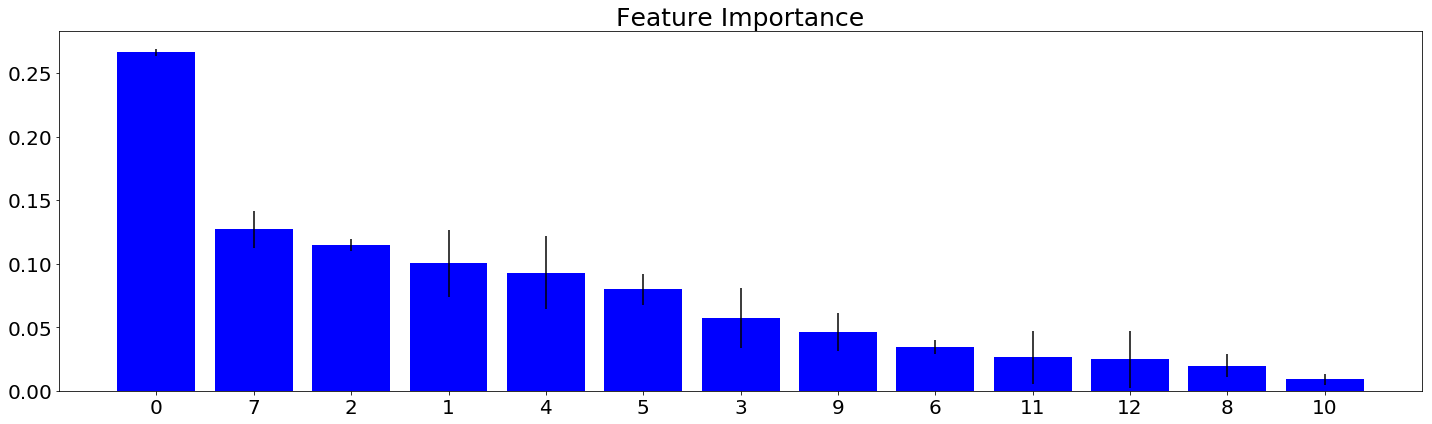

In [231]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,6))
#ax = fig.add_subplot(1,1,1)
#ax = sns.barplot(x = importances[indices], y = importances)
plt.bar(range(X.shape[1]), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])

plt.yticks(fontsize = 20, rotation='horizontal') #makes the ylabels horizontal
plt.xticks(fontsize = 20, rotation='horizontal') #makes the xlabels vertical

plt.title('Feature Importance', fontsize = 25)
#plt.savefig('images/feature_importance.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

/Users/sarahlewis/ENTER/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


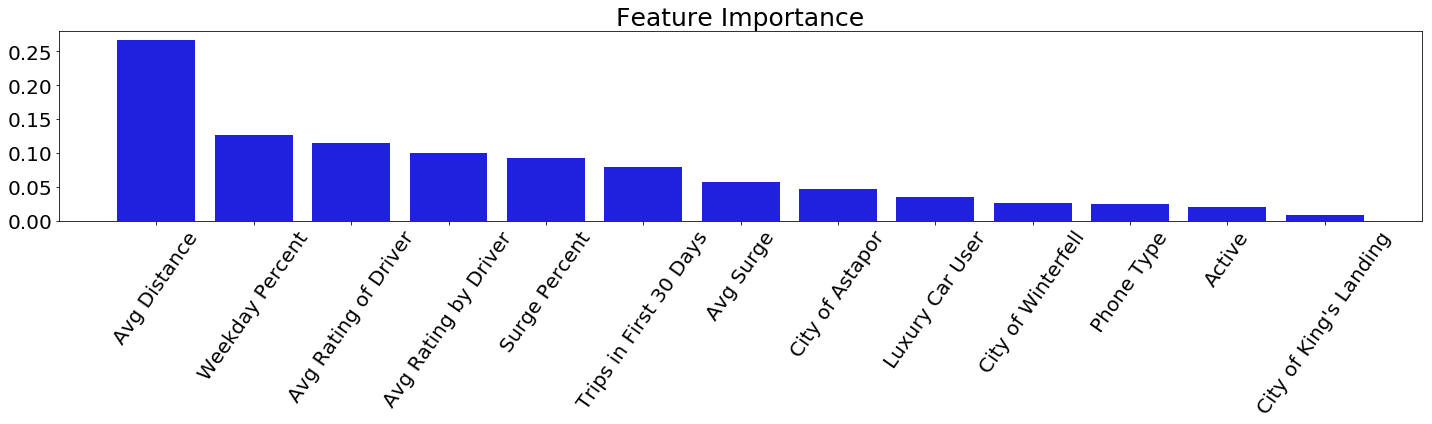

In [261]:
plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
ax = sns.barplot(indices, y = importances[indices], order = np.argsort(importances)[::-1], color = 'b')
plt.xlim([-1, X.shape[1]])

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Avg Distance'
labels[1] = 'Weekday Percent'
labels[2] = 'Avg Rating of Driver'
labels[3] = 'Avg Rating by Driver'
labels[4] = 'Surge Percent'
labels[5] = 'Trips in First 30 Days'
labels[6] = 'Avg Surge'
labels[7] = 'City of Astapor'
labels[8] = 'Luxury Car User'
labels[9] = 'City of Winterfell'
labels[10] = 'Phone Type'
labels[11] = 'Active'
labels[12] = "City of King's Landing"
ax.set_xticklabels(labels)

plt.yticks(fontsize = 20, rotation='horizontal') #makes the ylabels horizontal
plt.xticks(fontsize = 20, rotation=55) #makes the xlabels vertical

plt.title('Feature Importance', fontsize = 25)
plt.savefig('images/feature_importance.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [258]:
df_train2 = pd.read_csv('data/churn_train.csv')

In [259]:
df_train2 = clean_fill_nulls(df_train2)

[MICE] Completing matrix with shape (40000, 14)
[MICE] Starting imputation round 1/6710, elapsed time 0.023
[MICE] Starting imputation round 2/6710, elapsed time 0.705
[MICE] Starting imputation round 3/6710, elapsed time 0.733
[MICE] Starting imputation round 4/6710, elapsed time 0.759
[MICE] Starting imputation round 5/6710, elapsed time 0.789
[MICE] Starting imputation round 6/6710, elapsed time 0.821
[MICE] Starting imputation round 7/6710, elapsed time 0.850
[MICE] Starting imputation round 8/6710, elapsed time 0.877
[MICE] Starting imputation round 9/6710, elapsed time 0.903
[MICE] Starting imputation round 10/6710, elapsed time 0.933
[MICE] Starting imputation round 11/6710, elapsed time 0.964
[MICE] Starting imputation round 12/6710, elapsed time 0.991
[MICE] Starting imputation round 13/6710, elapsed time 1.019
[MICE] Starting imputation round 14/6710, elapsed time 1.046
[MICE] Starting imputation round 15/6710, elapsed time 1.073
[MICE] Starting imputation round 16/6710, elap

[MICE] Starting imputation round 138/6710, elapsed time 7.665
[MICE] Starting imputation round 139/6710, elapsed time 7.701
[MICE] Starting imputation round 140/6710, elapsed time 7.730
[MICE] Starting imputation round 141/6710, elapsed time 7.757
[MICE] Starting imputation round 142/6710, elapsed time 7.785
[MICE] Starting imputation round 143/6710, elapsed time 7.840
[MICE] Starting imputation round 144/6710, elapsed time 7.867
[MICE] Starting imputation round 145/6710, elapsed time 7.898
[MICE] Starting imputation round 146/6710, elapsed time 7.928
[MICE] Starting imputation round 147/6710, elapsed time 7.957
[MICE] Starting imputation round 148/6710, elapsed time 7.984
[MICE] Starting imputation round 149/6710, elapsed time 8.011
[MICE] Starting imputation round 150/6710, elapsed time 8.061
[MICE] Starting imputation round 151/6710, elapsed time 8.088
[MICE] Starting imputation round 152/6710, elapsed time 8.116
[MICE] Starting imputation round 153/6710, elapsed time 8.148
[MICE] S

[MICE] Starting imputation round 274/6710, elapsed time 12.802
[MICE] Starting imputation round 275/6710, elapsed time 12.834
[MICE] Starting imputation round 276/6710, elapsed time 12.865
[MICE] Starting imputation round 277/6710, elapsed time 12.897
[MICE] Starting imputation round 278/6710, elapsed time 12.927
[MICE] Starting imputation round 279/6710, elapsed time 12.958
[MICE] Starting imputation round 280/6710, elapsed time 12.989
[MICE] Starting imputation round 281/6710, elapsed time 13.023
[MICE] Starting imputation round 282/6710, elapsed time 13.054
[MICE] Starting imputation round 283/6710, elapsed time 13.086
[MICE] Starting imputation round 284/6710, elapsed time 13.115
[MICE] Starting imputation round 285/6710, elapsed time 13.145
[MICE] Starting imputation round 286/6710, elapsed time 13.233
[MICE] Starting imputation round 287/6710, elapsed time 13.287
[MICE] Starting imputation round 288/6710, elapsed time 13.320
[MICE] Starting imputation round 289/6710, elapsed time

[MICE] Starting imputation round 411/6710, elapsed time 17.387
[MICE] Starting imputation round 412/6710, elapsed time 17.420
[MICE] Starting imputation round 413/6710, elapsed time 17.447
[MICE] Starting imputation round 414/6710, elapsed time 17.475
[MICE] Starting imputation round 415/6710, elapsed time 17.503
[MICE] Starting imputation round 416/6710, elapsed time 17.530
[MICE] Starting imputation round 417/6710, elapsed time 17.557
[MICE] Starting imputation round 418/6710, elapsed time 17.585
[MICE] Starting imputation round 419/6710, elapsed time 17.616
[MICE] Starting imputation round 420/6710, elapsed time 17.647
[MICE] Starting imputation round 421/6710, elapsed time 17.676
[MICE] Starting imputation round 422/6710, elapsed time 17.715
[MICE] Starting imputation round 423/6710, elapsed time 17.753
[MICE] Starting imputation round 424/6710, elapsed time 17.782
[MICE] Starting imputation round 425/6710, elapsed time 17.810
[MICE] Starting imputation round 426/6710, elapsed time

[MICE] Starting imputation round 547/6710, elapsed time 21.687
[MICE] Starting imputation round 548/6710, elapsed time 21.719
[MICE] Starting imputation round 549/6710, elapsed time 21.747
[MICE] Starting imputation round 550/6710, elapsed time 21.774
[MICE] Starting imputation round 551/6710, elapsed time 21.804
[MICE] Starting imputation round 552/6710, elapsed time 21.847
[MICE] Starting imputation round 553/6710, elapsed time 21.873
[MICE] Starting imputation round 554/6710, elapsed time 21.902
[MICE] Starting imputation round 555/6710, elapsed time 21.929
[MICE] Starting imputation round 556/6710, elapsed time 21.962
[MICE] Starting imputation round 557/6710, elapsed time 21.990
[MICE] Starting imputation round 558/6710, elapsed time 22.017
[MICE] Starting imputation round 559/6710, elapsed time 22.044
[MICE] Starting imputation round 560/6710, elapsed time 22.072
[MICE] Starting imputation round 561/6710, elapsed time 22.100
[MICE] Starting imputation round 562/6710, elapsed time

[MICE] Starting imputation round 681/6710, elapsed time 25.762
[MICE] Starting imputation round 682/6710, elapsed time 25.795
[MICE] Starting imputation round 683/6710, elapsed time 25.824
[MICE] Starting imputation round 684/6710, elapsed time 25.872
[MICE] Starting imputation round 685/6710, elapsed time 25.899
[MICE] Starting imputation round 686/6710, elapsed time 25.927
[MICE] Starting imputation round 687/6710, elapsed time 25.955
[MICE] Starting imputation round 688/6710, elapsed time 25.986
[MICE] Starting imputation round 689/6710, elapsed time 26.014
[MICE] Starting imputation round 690/6710, elapsed time 26.044
[MICE] Starting imputation round 691/6710, elapsed time 26.072
[MICE] Starting imputation round 692/6710, elapsed time 26.099
[MICE] Starting imputation round 693/6710, elapsed time 26.127
[MICE] Starting imputation round 694/6710, elapsed time 26.154
[MICE] Starting imputation round 695/6710, elapsed time 26.184
[MICE] Starting imputation round 696/6710, elapsed time

[MICE] Starting imputation round 813/6710, elapsed time 29.639
[MICE] Starting imputation round 814/6710, elapsed time 29.670
[MICE] Starting imputation round 815/6710, elapsed time 29.699
[MICE] Starting imputation round 816/6710, elapsed time 29.726
[MICE] Starting imputation round 817/6710, elapsed time 29.754
[MICE] Starting imputation round 818/6710, elapsed time 29.783
[MICE] Starting imputation round 819/6710, elapsed time 29.813
[MICE] Starting imputation round 820/6710, elapsed time 29.841
[MICE] Starting imputation round 821/6710, elapsed time 29.874
[MICE] Starting imputation round 822/6710, elapsed time 29.902
[MICE] Starting imputation round 823/6710, elapsed time 29.929
[MICE] Starting imputation round 824/6710, elapsed time 29.956
[MICE] Starting imputation round 825/6710, elapsed time 29.984
[MICE] Starting imputation round 826/6710, elapsed time 30.011
[MICE] Starting imputation round 827/6710, elapsed time 30.039
[MICE] Starting imputation round 828/6710, elapsed time

[MICE] Starting imputation round 945/6710, elapsed time 33.451
[MICE] Starting imputation round 946/6710, elapsed time 33.482
[MICE] Starting imputation round 947/6710, elapsed time 33.511
[MICE] Starting imputation round 948/6710, elapsed time 33.538
[MICE] Starting imputation round 949/6710, elapsed time 33.566
[MICE] Starting imputation round 950/6710, elapsed time 33.593
[MICE] Starting imputation round 951/6710, elapsed time 33.620
[MICE] Starting imputation round 952/6710, elapsed time 33.647
[MICE] Starting imputation round 953/6710, elapsed time 33.676
[MICE] Starting imputation round 954/6710, elapsed time 33.707
[MICE] Starting imputation round 955/6710, elapsed time 33.757
[MICE] Starting imputation round 956/6710, elapsed time 33.820
[MICE] Starting imputation round 957/6710, elapsed time 33.854
[MICE] Starting imputation round 958/6710, elapsed time 33.890
[MICE] Starting imputation round 959/6710, elapsed time 33.937
[MICE] Starting imputation round 960/6710, elapsed time

[MICE] Starting imputation round 1078/6710, elapsed time 37.924
[MICE] Starting imputation round 1079/6710, elapsed time 37.954
[MICE] Starting imputation round 1080/6710, elapsed time 37.981
[MICE] Starting imputation round 1081/6710, elapsed time 38.008
[MICE] Starting imputation round 1082/6710, elapsed time 38.036
[MICE] Starting imputation round 1083/6710, elapsed time 38.062
[MICE] Starting imputation round 1084/6710, elapsed time 38.089
[MICE] Starting imputation round 1085/6710, elapsed time 38.117
[MICE] Starting imputation round 1086/6710, elapsed time 38.158
[MICE] Starting imputation round 1087/6710, elapsed time 38.192
[MICE] Starting imputation round 1088/6710, elapsed time 38.221
[MICE] Starting imputation round 1089/6710, elapsed time 38.249
[MICE] Starting imputation round 1090/6710, elapsed time 38.277
[MICE] Starting imputation round 1091/6710, elapsed time 38.304
[MICE] Starting imputation round 1092/6710, elapsed time 38.333
[MICE] Starting imputation round 1093/67

[MICE] Starting imputation round 1207/6710, elapsed time 41.831
[MICE] Starting imputation round 1208/6710, elapsed time 41.861
[MICE] Starting imputation round 1209/6710, elapsed time 41.888
[MICE] Starting imputation round 1210/6710, elapsed time 41.916
[MICE] Starting imputation round 1211/6710, elapsed time 41.943
[MICE] Starting imputation round 1212/6710, elapsed time 41.969
[MICE] Starting imputation round 1213/6710, elapsed time 41.996
[MICE] Starting imputation round 1214/6710, elapsed time 42.022
[MICE] Starting imputation round 1215/6710, elapsed time 42.050
[MICE] Starting imputation round 1216/6710, elapsed time 42.097
[MICE] Starting imputation round 1217/6710, elapsed time 42.124
[MICE] Starting imputation round 1218/6710, elapsed time 42.154
[MICE] Starting imputation round 1219/6710, elapsed time 42.181
[MICE] Starting imputation round 1220/6710, elapsed time 42.210
[MICE] Starting imputation round 1221/6710, elapsed time 42.237
[MICE] Starting imputation round 1222/67

[MICE] Starting imputation round 1337/6710, elapsed time 45.816
[MICE] Starting imputation round 1338/6710, elapsed time 45.847
[MICE] Starting imputation round 1339/6710, elapsed time 45.875
[MICE] Starting imputation round 1340/6710, elapsed time 45.903
[MICE] Starting imputation round 1341/6710, elapsed time 45.930
[MICE] Starting imputation round 1342/6710, elapsed time 45.957
[MICE] Starting imputation round 1343/6710, elapsed time 45.984
[MICE] Starting imputation round 1344/6710, elapsed time 46.030
[MICE] Starting imputation round 1345/6710, elapsed time 46.057
[MICE] Starting imputation round 1346/6710, elapsed time 46.086
[MICE] Starting imputation round 1347/6710, elapsed time 46.123
[MICE] Starting imputation round 1348/6710, elapsed time 46.151
[MICE] Starting imputation round 1349/6710, elapsed time 46.180
[MICE] Starting imputation round 1350/6710, elapsed time 46.210
[MICE] Starting imputation round 1351/6710, elapsed time 46.237
[MICE] Starting imputation round 1352/67

[MICE] Starting imputation round 1467/6710, elapsed time 49.982
[MICE] Starting imputation round 1468/6710, elapsed time 50.015
[MICE] Starting imputation round 1469/6710, elapsed time 50.042
[MICE] Starting imputation round 1470/6710, elapsed time 50.068
[MICE] Starting imputation round 1471/6710, elapsed time 50.097
[MICE] Starting imputation round 1472/6710, elapsed time 50.125
[MICE] Starting imputation round 1473/6710, elapsed time 50.152
[MICE] Starting imputation round 1474/6710, elapsed time 50.181
[MICE] Starting imputation round 1475/6710, elapsed time 50.214
[MICE] Starting imputation round 1476/6710, elapsed time 50.244
[MICE] Starting imputation round 1477/6710, elapsed time 50.274
[MICE] Starting imputation round 1478/6710, elapsed time 50.303
[MICE] Starting imputation round 1479/6710, elapsed time 50.331
[MICE] Starting imputation round 1480/6710, elapsed time 50.359
[MICE] Starting imputation round 1481/6710, elapsed time 50.387
[MICE] Starting imputation round 1482/67

[MICE] Starting imputation round 1601/6710, elapsed time 54.036
[MICE] Starting imputation round 1602/6710, elapsed time 54.064
[MICE] Starting imputation round 1603/6710, elapsed time 54.091
[MICE] Starting imputation round 1604/6710, elapsed time 54.121
[MICE] Starting imputation round 1605/6710, elapsed time 54.150
[MICE] Starting imputation round 1606/6710, elapsed time 54.179
[MICE] Starting imputation round 1607/6710, elapsed time 54.208
[MICE] Starting imputation round 1608/6710, elapsed time 54.235
[MICE] Starting imputation round 1609/6710, elapsed time 54.265
[MICE] Starting imputation round 1610/6710, elapsed time 54.298
[MICE] Starting imputation round 1611/6710, elapsed time 54.328
[MICE] Starting imputation round 1612/6710, elapsed time 54.357
[MICE] Starting imputation round 1613/6710, elapsed time 54.386
[MICE] Starting imputation round 1614/6710, elapsed time 54.414
[MICE] Starting imputation round 1615/6710, elapsed time 54.441
[MICE] Starting imputation round 1616/67

[MICE] Starting imputation round 1735/6710, elapsed time 57.962
[MICE] Starting imputation round 1736/6710, elapsed time 58.001
[MICE] Starting imputation round 1737/6710, elapsed time 58.033
[MICE] Starting imputation round 1738/6710, elapsed time 58.063
[MICE] Starting imputation round 1739/6710, elapsed time 58.091
[MICE] Starting imputation round 1740/6710, elapsed time 58.121
[MICE] Starting imputation round 1741/6710, elapsed time 58.149
[MICE] Starting imputation round 1742/6710, elapsed time 58.179
[MICE] Starting imputation round 1743/6710, elapsed time 58.215
[MICE] Starting imputation round 1744/6710, elapsed time 58.243
[MICE] Starting imputation round 1745/6710, elapsed time 58.272
[MICE] Starting imputation round 1746/6710, elapsed time 58.301
[MICE] Starting imputation round 1747/6710, elapsed time 58.330
[MICE] Starting imputation round 1748/6710, elapsed time 58.360
[MICE] Starting imputation round 1749/6710, elapsed time 58.390
[MICE] Starting imputation round 1750/67

[MICE] Starting imputation round 1866/6710, elapsed time 62.574
[MICE] Starting imputation round 1867/6710, elapsed time 62.607
[MICE] Starting imputation round 1868/6710, elapsed time 62.635
[MICE] Starting imputation round 1869/6710, elapsed time 62.662
[MICE] Starting imputation round 1870/6710, elapsed time 62.689
[MICE] Starting imputation round 1871/6710, elapsed time 62.717
[MICE] Starting imputation round 1872/6710, elapsed time 62.745
[MICE] Starting imputation round 1873/6710, elapsed time 62.776
[MICE] Starting imputation round 1874/6710, elapsed time 62.810
[MICE] Starting imputation round 1875/6710, elapsed time 62.839
[MICE] Starting imputation round 1876/6710, elapsed time 62.866
[MICE] Starting imputation round 1877/6710, elapsed time 62.894
[MICE] Starting imputation round 1878/6710, elapsed time 62.922
[MICE] Starting imputation round 1879/6710, elapsed time 62.949
[MICE] Starting imputation round 1880/6710, elapsed time 62.978
[MICE] Starting imputation round 1881/67

[MICE] Starting imputation round 1998/6710, elapsed time 66.645
[MICE] Starting imputation round 1999/6710, elapsed time 66.681
[MICE] Starting imputation round 2000/6710, elapsed time 66.710
[MICE] Starting imputation round 2001/6710, elapsed time 66.738
[MICE] Starting imputation round 2002/6710, elapsed time 66.768
[MICE] Starting imputation round 2003/6710, elapsed time 66.797
[MICE] Starting imputation round 2004/6710, elapsed time 66.825
[MICE] Starting imputation round 2005/6710, elapsed time 66.853
[MICE] Starting imputation round 2006/6710, elapsed time 66.884
[MICE] Starting imputation round 2007/6710, elapsed time 66.915
[MICE] Starting imputation round 2008/6710, elapsed time 66.947
[MICE] Starting imputation round 2009/6710, elapsed time 66.975
[MICE] Starting imputation round 2010/6710, elapsed time 67.004
[MICE] Starting imputation round 2011/6710, elapsed time 67.032
[MICE] Starting imputation round 2012/6710, elapsed time 67.065
[MICE] Starting imputation round 2013/67

[MICE] Starting imputation round 2129/6710, elapsed time 70.800
[MICE] Starting imputation round 2130/6710, elapsed time 70.828
[MICE] Starting imputation round 2131/6710, elapsed time 70.868
[MICE] Starting imputation round 2132/6710, elapsed time 70.897
[MICE] Starting imputation round 2133/6710, elapsed time 70.929
[MICE] Starting imputation round 2134/6710, elapsed time 70.960
[MICE] Starting imputation round 2135/6710, elapsed time 70.990
[MICE] Starting imputation round 2136/6710, elapsed time 71.022
[MICE] Starting imputation round 2137/6710, elapsed time 71.054
[MICE] Starting imputation round 2138/6710, elapsed time 71.088
[MICE] Starting imputation round 2139/6710, elapsed time 71.131
[MICE] Starting imputation round 2140/6710, elapsed time 71.161
[MICE] Starting imputation round 2141/6710, elapsed time 71.191
[MICE] Starting imputation round 2142/6710, elapsed time 71.223
[MICE] Starting imputation round 2143/6710, elapsed time 71.254
[MICE] Starting imputation round 2144/67

[MICE] Starting imputation round 2258/6710, elapsed time 75.279
[MICE] Starting imputation round 2259/6710, elapsed time 75.315
[MICE] Starting imputation round 2260/6710, elapsed time 75.352
[MICE] Starting imputation round 2261/6710, elapsed time 75.385
[MICE] Starting imputation round 2262/6710, elapsed time 75.418
[MICE] Starting imputation round 2263/6710, elapsed time 75.454
[MICE] Starting imputation round 2264/6710, elapsed time 75.483
[MICE] Starting imputation round 2265/6710, elapsed time 75.521
[MICE] Starting imputation round 2266/6710, elapsed time 75.566
[MICE] Starting imputation round 2267/6710, elapsed time 75.656
[MICE] Starting imputation round 2268/6710, elapsed time 75.688
[MICE] Starting imputation round 2269/6710, elapsed time 75.721
[MICE] Starting imputation round 2270/6710, elapsed time 75.759
[MICE] Starting imputation round 2271/6710, elapsed time 75.796
[MICE] Starting imputation round 2272/6710, elapsed time 75.832
[MICE] Starting imputation round 2273/67

[MICE] Starting imputation round 2388/6710, elapsed time 79.635
[MICE] Starting imputation round 2389/6710, elapsed time 79.672
[MICE] Starting imputation round 2390/6710, elapsed time 79.701
[MICE] Starting imputation round 2391/6710, elapsed time 79.732
[MICE] Starting imputation round 2392/6710, elapsed time 79.762
[MICE] Starting imputation round 2393/6710, elapsed time 79.791
[MICE] Starting imputation round 2394/6710, elapsed time 79.821
[MICE] Starting imputation round 2395/6710, elapsed time 79.852
[MICE] Starting imputation round 2396/6710, elapsed time 79.886
[MICE] Starting imputation round 2397/6710, elapsed time 79.915
[MICE] Starting imputation round 2398/6710, elapsed time 79.944
[MICE] Starting imputation round 2399/6710, elapsed time 79.972
[MICE] Starting imputation round 2400/6710, elapsed time 80.000
[MICE] Starting imputation round 2401/6710, elapsed time 80.034
[MICE] Starting imputation round 2402/6710, elapsed time 80.063
[MICE] Starting imputation round 2403/67

[MICE] Starting imputation round 2521/6710, elapsed time 83.820
[MICE] Starting imputation round 2522/6710, elapsed time 83.851
[MICE] Starting imputation round 2523/6710, elapsed time 83.878
[MICE] Starting imputation round 2524/6710, elapsed time 83.906
[MICE] Starting imputation round 2525/6710, elapsed time 83.934
[MICE] Starting imputation round 2526/6710, elapsed time 83.962
[MICE] Starting imputation round 2527/6710, elapsed time 83.989
[MICE] Starting imputation round 2528/6710, elapsed time 84.024
[MICE] Starting imputation round 2529/6710, elapsed time 84.064
[MICE] Starting imputation round 2530/6710, elapsed time 84.099
[MICE] Starting imputation round 2531/6710, elapsed time 84.130
[MICE] Starting imputation round 2532/6710, elapsed time 84.159
[MICE] Starting imputation round 2533/6710, elapsed time 84.186
[MICE] Starting imputation round 2534/6710, elapsed time 84.217
[MICE] Starting imputation round 2535/6710, elapsed time 84.279
[MICE] Starting imputation round 2536/67

[MICE] Starting imputation round 2654/6710, elapsed time 88.359
[MICE] Starting imputation round 2655/6710, elapsed time 88.390
[MICE] Starting imputation round 2656/6710, elapsed time 88.419
[MICE] Starting imputation round 2657/6710, elapsed time 88.449
[MICE] Starting imputation round 2658/6710, elapsed time 88.477
[MICE] Starting imputation round 2659/6710, elapsed time 88.507
[MICE] Starting imputation round 2660/6710, elapsed time 88.538
[MICE] Starting imputation round 2661/6710, elapsed time 88.590
[MICE] Starting imputation round 2662/6710, elapsed time 88.631
[MICE] Starting imputation round 2663/6710, elapsed time 88.660
[MICE] Starting imputation round 2664/6710, elapsed time 88.690
[MICE] Starting imputation round 2665/6710, elapsed time 88.749
[MICE] Starting imputation round 2666/6710, elapsed time 88.779
[MICE] Starting imputation round 2667/6710, elapsed time 88.809
[MICE] Starting imputation round 2668/6710, elapsed time 88.853
[MICE] Starting imputation round 2669/67

[MICE] Starting imputation round 2787/6710, elapsed time 92.863
[MICE] Starting imputation round 2788/6710, elapsed time 92.895
[MICE] Starting imputation round 2789/6710, elapsed time 92.924
[MICE] Starting imputation round 2790/6710, elapsed time 92.951
[MICE] Starting imputation round 2791/6710, elapsed time 92.978
[MICE] Starting imputation round 2792/6710, elapsed time 93.005
[MICE] Starting imputation round 2793/6710, elapsed time 93.032
[MICE] Starting imputation round 2794/6710, elapsed time 93.059
[MICE] Starting imputation round 2795/6710, elapsed time 93.089
[MICE] Starting imputation round 2796/6710, elapsed time 93.124
[MICE] Starting imputation round 2797/6710, elapsed time 93.151
[MICE] Starting imputation round 2798/6710, elapsed time 93.178
[MICE] Starting imputation round 2799/6710, elapsed time 93.205
[MICE] Starting imputation round 2800/6710, elapsed time 93.233
[MICE] Starting imputation round 2801/6710, elapsed time 93.260
[MICE] Starting imputation round 2802/67

[MICE] Starting imputation round 2916/6710, elapsed time 96.899
[MICE] Starting imputation round 2917/6710, elapsed time 96.935
[MICE] Starting imputation round 2918/6710, elapsed time 96.965
[MICE] Starting imputation round 2919/6710, elapsed time 96.995
[MICE] Starting imputation round 2920/6710, elapsed time 97.025
[MICE] Starting imputation round 2921/6710, elapsed time 97.054
[MICE] Starting imputation round 2922/6710, elapsed time 97.084
[MICE] Starting imputation round 2923/6710, elapsed time 97.114
[MICE] Starting imputation round 2924/6710, elapsed time 97.147
[MICE] Starting imputation round 2925/6710, elapsed time 97.178
[MICE] Starting imputation round 2926/6710, elapsed time 97.208
[MICE] Starting imputation round 2927/6710, elapsed time 97.236
[MICE] Starting imputation round 2928/6710, elapsed time 97.264
[MICE] Starting imputation round 2929/6710, elapsed time 97.292
[MICE] Starting imputation round 2930/6710, elapsed time 97.349
[MICE] Starting imputation round 2931/67

[MICE] Starting imputation round 3044/6710, elapsed time 100.855
[MICE] Starting imputation round 3045/6710, elapsed time 100.886
[MICE] Starting imputation round 3046/6710, elapsed time 100.915
[MICE] Starting imputation round 3047/6710, elapsed time 100.942
[MICE] Starting imputation round 3048/6710, elapsed time 100.969
[MICE] Starting imputation round 3049/6710, elapsed time 100.997
[MICE] Starting imputation round 3050/6710, elapsed time 101.026
[MICE] Starting imputation round 3051/6710, elapsed time 101.053
[MICE] Starting imputation round 3052/6710, elapsed time 101.087
[MICE] Starting imputation round 3053/6710, elapsed time 101.115
[MICE] Starting imputation round 3054/6710, elapsed time 101.143
[MICE] Starting imputation round 3055/6710, elapsed time 101.170
[MICE] Starting imputation round 3056/6710, elapsed time 101.197
[MICE] Starting imputation round 3057/6710, elapsed time 101.225
[MICE] Starting imputation round 3058/6710, elapsed time 101.253
[MICE] Starting imputatio

[MICE] Starting imputation round 3173/6710, elapsed time 104.909
[MICE] Starting imputation round 3174/6710, elapsed time 104.937
[MICE] Starting imputation round 3175/6710, elapsed time 104.965
[MICE] Starting imputation round 3176/6710, elapsed time 104.992
[MICE] Starting imputation round 3177/6710, elapsed time 105.023
[MICE] Starting imputation round 3178/6710, elapsed time 105.059
[MICE] Starting imputation round 3179/6710, elapsed time 105.090
[MICE] Starting imputation round 3180/6710, elapsed time 105.125
[MICE] Starting imputation round 3181/6710, elapsed time 105.164
[MICE] Starting imputation round 3182/6710, elapsed time 105.195
[MICE] Starting imputation round 3183/6710, elapsed time 105.228
[MICE] Starting imputation round 3184/6710, elapsed time 105.260
[MICE] Starting imputation round 3185/6710, elapsed time 105.289
[MICE] Starting imputation round 3186/6710, elapsed time 105.319
[MICE] Starting imputation round 3187/6710, elapsed time 105.353
[MICE] Starting imputatio

[MICE] Starting imputation round 3302/6710, elapsed time 109.015
[MICE] Starting imputation round 3303/6710, elapsed time 109.047
[MICE] Starting imputation round 3304/6710, elapsed time 109.074
[MICE] Starting imputation round 3305/6710, elapsed time 109.102
[MICE] Starting imputation round 3306/6710, elapsed time 109.129
[MICE] Starting imputation round 3307/6710, elapsed time 109.156
[MICE] Starting imputation round 3308/6710, elapsed time 109.183
[MICE] Starting imputation round 3309/6710, elapsed time 109.215
[MICE] Starting imputation round 3310/6710, elapsed time 109.248
[MICE] Starting imputation round 3311/6710, elapsed time 109.280
[MICE] Starting imputation round 3312/6710, elapsed time 109.316
[MICE] Starting imputation round 3313/6710, elapsed time 109.360
[MICE] Starting imputation round 3314/6710, elapsed time 109.390
[MICE] Starting imputation round 3315/6710, elapsed time 109.421
[MICE] Starting imputation round 3316/6710, elapsed time 109.449
[MICE] Starting imputatio

[MICE] Starting imputation round 3430/6710, elapsed time 113.059
[MICE] Starting imputation round 3431/6710, elapsed time 113.103
[MICE] Starting imputation round 3432/6710, elapsed time 113.136
[MICE] Starting imputation round 3433/6710, elapsed time 113.166
[MICE] Starting imputation round 3434/6710, elapsed time 113.199
[MICE] Starting imputation round 3435/6710, elapsed time 113.230
[MICE] Starting imputation round 3436/6710, elapsed time 113.260
[MICE] Starting imputation round 3437/6710, elapsed time 113.295
[MICE] Starting imputation round 3438/6710, elapsed time 113.329
[MICE] Starting imputation round 3439/6710, elapsed time 113.362
[MICE] Starting imputation round 3440/6710, elapsed time 113.397
[MICE] Starting imputation round 3441/6710, elapsed time 113.424
[MICE] Starting imputation round 3442/6710, elapsed time 113.450
[MICE] Starting imputation round 3443/6710, elapsed time 113.478
[MICE] Starting imputation round 3444/6710, elapsed time 113.510
[MICE] Starting imputatio

[MICE] Starting imputation round 3559/6710, elapsed time 116.943
[MICE] Starting imputation round 3560/6710, elapsed time 116.971
[MICE] Starting imputation round 3561/6710, elapsed time 116.998
[MICE] Starting imputation round 3562/6710, elapsed time 117.025
[MICE] Starting imputation round 3563/6710, elapsed time 117.053
[MICE] Starting imputation round 3564/6710, elapsed time 117.090
[MICE] Starting imputation round 3565/6710, elapsed time 117.126
[MICE] Starting imputation round 3566/6710, elapsed time 117.161
[MICE] Starting imputation round 3567/6710, elapsed time 117.199
[MICE] Starting imputation round 3568/6710, elapsed time 117.233
[MICE] Starting imputation round 3569/6710, elapsed time 117.263
[MICE] Starting imputation round 3570/6710, elapsed time 117.292
[MICE] Starting imputation round 3571/6710, elapsed time 117.320
[MICE] Starting imputation round 3572/6710, elapsed time 117.355
[MICE] Starting imputation round 3573/6710, elapsed time 117.394
[MICE] Starting imputatio

[MICE] Starting imputation round 3692/6710, elapsed time 121.002
[MICE] Starting imputation round 3693/6710, elapsed time 121.046
[MICE] Starting imputation round 3694/6710, elapsed time 121.090
[MICE] Starting imputation round 3695/6710, elapsed time 121.128
[MICE] Starting imputation round 3696/6710, elapsed time 121.166
[MICE] Starting imputation round 3697/6710, elapsed time 121.206
[MICE] Starting imputation round 3698/6710, elapsed time 121.267
[MICE] Starting imputation round 3699/6710, elapsed time 121.300
[MICE] Starting imputation round 3700/6710, elapsed time 121.351
[MICE] Starting imputation round 3701/6710, elapsed time 121.394
[MICE] Starting imputation round 3702/6710, elapsed time 121.434
[MICE] Starting imputation round 3703/6710, elapsed time 121.480
[MICE] Starting imputation round 3704/6710, elapsed time 121.518
[MICE] Starting imputation round 3705/6710, elapsed time 121.564
[MICE] Starting imputation round 3706/6710, elapsed time 121.605
[MICE] Starting imputatio

[MICE] Starting imputation round 3818/6710, elapsed time 125.591
[MICE] Starting imputation round 3819/6710, elapsed time 125.620
[MICE] Starting imputation round 3820/6710, elapsed time 125.650
[MICE] Starting imputation round 3821/6710, elapsed time 125.712
[MICE] Starting imputation round 3822/6710, elapsed time 125.740
[MICE] Starting imputation round 3823/6710, elapsed time 125.769
[MICE] Starting imputation round 3824/6710, elapsed time 125.802
[MICE] Starting imputation round 3825/6710, elapsed time 125.844
[MICE] Starting imputation round 3826/6710, elapsed time 125.895
[MICE] Starting imputation round 3827/6710, elapsed time 125.948
[MICE] Starting imputation round 3828/6710, elapsed time 125.989
[MICE] Starting imputation round 3829/6710, elapsed time 126.032
[MICE] Starting imputation round 3830/6710, elapsed time 126.085
[MICE] Starting imputation round 3831/6710, elapsed time 126.122
[MICE] Starting imputation round 3832/6710, elapsed time 126.150
[MICE] Starting imputatio

[MICE] Starting imputation round 3948/6710, elapsed time 130.711
[MICE] Starting imputation round 3949/6710, elapsed time 130.752
[MICE] Starting imputation round 3950/6710, elapsed time 130.782
[MICE] Starting imputation round 3951/6710, elapsed time 130.831
[MICE] Starting imputation round 3952/6710, elapsed time 130.872
[MICE] Starting imputation round 3953/6710, elapsed time 130.902
[MICE] Starting imputation round 3954/6710, elapsed time 130.936
[MICE] Starting imputation round 3955/6710, elapsed time 130.974
[MICE] Starting imputation round 3956/6710, elapsed time 131.007
[MICE] Starting imputation round 3957/6710, elapsed time 131.036
[MICE] Starting imputation round 3958/6710, elapsed time 131.064
[MICE] Starting imputation round 3959/6710, elapsed time 131.101
[MICE] Starting imputation round 3960/6710, elapsed time 131.133
[MICE] Starting imputation round 3961/6710, elapsed time 131.187
[MICE] Starting imputation round 3962/6710, elapsed time 131.216
[MICE] Starting imputatio

[MICE] Starting imputation round 4078/6710, elapsed time 134.877
[MICE] Starting imputation round 4079/6710, elapsed time 134.909
[MICE] Starting imputation round 4080/6710, elapsed time 134.960
[MICE] Starting imputation round 4081/6710, elapsed time 134.988
[MICE] Starting imputation round 4082/6710, elapsed time 135.015
[MICE] Starting imputation round 4083/6710, elapsed time 135.042
[MICE] Starting imputation round 4084/6710, elapsed time 135.071
[MICE] Starting imputation round 4085/6710, elapsed time 135.103
[MICE] Starting imputation round 4086/6710, elapsed time 135.131
[MICE] Starting imputation round 4087/6710, elapsed time 135.160
[MICE] Starting imputation round 4088/6710, elapsed time 135.188
[MICE] Starting imputation round 4089/6710, elapsed time 135.215
[MICE] Starting imputation round 4090/6710, elapsed time 135.243
[MICE] Starting imputation round 4091/6710, elapsed time 135.270
[MICE] Starting imputation round 4092/6710, elapsed time 135.303
[MICE] Starting imputatio

[MICE] Starting imputation round 4209/6710, elapsed time 139.165
[MICE] Starting imputation round 4210/6710, elapsed time 139.199
[MICE] Starting imputation round 4211/6710, elapsed time 139.233
[MICE] Starting imputation round 4212/6710, elapsed time 139.264
[MICE] Starting imputation round 4213/6710, elapsed time 139.291
[MICE] Starting imputation round 4214/6710, elapsed time 139.318
[MICE] Starting imputation round 4215/6710, elapsed time 139.346
[MICE] Starting imputation round 4216/6710, elapsed time 139.375
[MICE] Starting imputation round 4217/6710, elapsed time 139.406
[MICE] Starting imputation round 4218/6710, elapsed time 139.442
[MICE] Starting imputation round 4219/6710, elapsed time 139.473
[MICE] Starting imputation round 4220/6710, elapsed time 139.502
[MICE] Starting imputation round 4221/6710, elapsed time 139.533
[MICE] Starting imputation round 4222/6710, elapsed time 139.561
[MICE] Starting imputation round 4223/6710, elapsed time 139.610
[MICE] Starting imputatio

[MICE] Starting imputation round 4342/6710, elapsed time 143.393
[MICE] Starting imputation round 4343/6710, elapsed time 143.422
[MICE] Starting imputation round 4344/6710, elapsed time 143.451
[MICE] Starting imputation round 4345/6710, elapsed time 143.479
[MICE] Starting imputation round 4346/6710, elapsed time 143.515
[MICE] Starting imputation round 4347/6710, elapsed time 143.544
[MICE] Starting imputation round 4348/6710, elapsed time 143.578
[MICE] Starting imputation round 4349/6710, elapsed time 143.608
[MICE] Starting imputation round 4350/6710, elapsed time 143.638
[MICE] Starting imputation round 4351/6710, elapsed time 143.666
[MICE] Starting imputation round 4352/6710, elapsed time 143.693
[MICE] Starting imputation round 4353/6710, elapsed time 143.722
[MICE] Starting imputation round 4354/6710, elapsed time 143.751
[MICE] Starting imputation round 4355/6710, elapsed time 143.780
[MICE] Starting imputation round 4356/6710, elapsed time 143.810
[MICE] Starting imputatio

[MICE] Starting imputation round 4469/6710, elapsed time 147.375
[MICE] Starting imputation round 4470/6710, elapsed time 147.426
[MICE] Starting imputation round 4471/6710, elapsed time 147.496
[MICE] Starting imputation round 4472/6710, elapsed time 147.586
[MICE] Starting imputation round 4473/6710, elapsed time 147.702
[MICE] Starting imputation round 4474/6710, elapsed time 147.783
[MICE] Starting imputation round 4475/6710, elapsed time 147.868
[MICE] Starting imputation round 4476/6710, elapsed time 147.946
[MICE] Starting imputation round 4477/6710, elapsed time 148.025
[MICE] Starting imputation round 4478/6710, elapsed time 148.085
[MICE] Starting imputation round 4479/6710, elapsed time 148.161
[MICE] Starting imputation round 4480/6710, elapsed time 148.208
[MICE] Starting imputation round 4481/6710, elapsed time 148.249
[MICE] Starting imputation round 4482/6710, elapsed time 148.374
[MICE] Starting imputation round 4483/6710, elapsed time 148.414
[MICE] Starting imputatio

[MICE] Starting imputation round 4596/6710, elapsed time 151.967
[MICE] Starting imputation round 4597/6710, elapsed time 151.997
[MICE] Starting imputation round 4598/6710, elapsed time 152.028
[MICE] Starting imputation round 4599/6710, elapsed time 152.055
[MICE] Starting imputation round 4600/6710, elapsed time 152.082
[MICE] Starting imputation round 4601/6710, elapsed time 152.110
[MICE] Starting imputation round 4602/6710, elapsed time 152.137
[MICE] Starting imputation round 4603/6710, elapsed time 152.163
[MICE] Starting imputation round 4604/6710, elapsed time 152.197
[MICE] Starting imputation round 4605/6710, elapsed time 152.224
[MICE] Starting imputation round 4606/6710, elapsed time 152.255
[MICE] Starting imputation round 4607/6710, elapsed time 152.283
[MICE] Starting imputation round 4608/6710, elapsed time 152.311
[MICE] Starting imputation round 4609/6710, elapsed time 152.340
[MICE] Starting imputation round 4610/6710, elapsed time 152.367
[MICE] Starting imputatio

[MICE] Starting imputation round 4726/6710, elapsed time 155.845
[MICE] Starting imputation round 4727/6710, elapsed time 155.886
[MICE] Starting imputation round 4728/6710, elapsed time 155.917
[MICE] Starting imputation round 4729/6710, elapsed time 155.945
[MICE] Starting imputation round 4730/6710, elapsed time 155.973
[MICE] Starting imputation round 4731/6710, elapsed time 156.002
[MICE] Starting imputation round 4732/6710, elapsed time 156.029
[MICE] Starting imputation round 4733/6710, elapsed time 156.058
[MICE] Starting imputation round 4734/6710, elapsed time 156.090
[MICE] Starting imputation round 4735/6710, elapsed time 156.120
[MICE] Starting imputation round 4736/6710, elapsed time 156.148
[MICE] Starting imputation round 4737/6710, elapsed time 156.176
[MICE] Starting imputation round 4738/6710, elapsed time 156.204
[MICE] Starting imputation round 4739/6710, elapsed time 156.231
[MICE] Starting imputation round 4740/6710, elapsed time 156.262
[MICE] Starting imputatio

[MICE] Starting imputation round 4860/6710, elapsed time 159.902
[MICE] Starting imputation round 4861/6710, elapsed time 159.939
[MICE] Starting imputation round 4862/6710, elapsed time 159.967
[MICE] Starting imputation round 4863/6710, elapsed time 159.995
[MICE] Starting imputation round 4864/6710, elapsed time 160.022
[MICE] Starting imputation round 4865/6710, elapsed time 160.051
[MICE] Starting imputation round 4866/6710, elapsed time 160.079
[MICE] Starting imputation round 4867/6710, elapsed time 160.111
[MICE] Starting imputation round 4868/6710, elapsed time 160.143
[MICE] Starting imputation round 4869/6710, elapsed time 160.171
[MICE] Starting imputation round 4870/6710, elapsed time 160.199
[MICE] Starting imputation round 4871/6710, elapsed time 160.230
[MICE] Starting imputation round 4872/6710, elapsed time 160.257
[MICE] Starting imputation round 4873/6710, elapsed time 160.285
[MICE] Starting imputation round 4874/6710, elapsed time 160.313
[MICE] Starting imputatio

[MICE] Starting imputation round 4991/6710, elapsed time 163.731
[MICE] Starting imputation round 4992/6710, elapsed time 163.759
[MICE] Starting imputation round 4993/6710, elapsed time 163.787
[MICE] Starting imputation round 4994/6710, elapsed time 163.814
[MICE] Starting imputation round 4995/6710, elapsed time 163.842
[MICE] Starting imputation round 4996/6710, elapsed time 163.869
[MICE] Starting imputation round 4997/6710, elapsed time 163.896
[MICE] Starting imputation round 4998/6710, elapsed time 163.923
[MICE] Starting imputation round 4999/6710, elapsed time 163.957
[MICE] Starting imputation round 5000/6710, elapsed time 163.990
[MICE] Starting imputation round 5001/6710, elapsed time 164.017
[MICE] Starting imputation round 5002/6710, elapsed time 164.044
[MICE] Starting imputation round 5003/6710, elapsed time 164.071
[MICE] Starting imputation round 5004/6710, elapsed time 164.098
[MICE] Starting imputation round 5005/6710, elapsed time 164.126
[MICE] Starting imputatio

[MICE] Starting imputation round 5126/6710, elapsed time 167.832
[MICE] Starting imputation round 5127/6710, elapsed time 167.863
[MICE] Starting imputation round 5128/6710, elapsed time 167.891
[MICE] Starting imputation round 5129/6710, elapsed time 167.917
[MICE] Starting imputation round 5130/6710, elapsed time 167.947
[MICE] Starting imputation round 5131/6710, elapsed time 167.975
[MICE] Starting imputation round 5132/6710, elapsed time 168.006
[MICE] Starting imputation round 5133/6710, elapsed time 168.034
[MICE] Starting imputation round 5134/6710, elapsed time 168.068
[MICE] Starting imputation round 5135/6710, elapsed time 168.098
[MICE] Starting imputation round 5136/6710, elapsed time 168.125
[MICE] Starting imputation round 5137/6710, elapsed time 168.152
[MICE] Starting imputation round 5138/6710, elapsed time 168.180
[MICE] Starting imputation round 5139/6710, elapsed time 168.207
[MICE] Starting imputation round 5140/6710, elapsed time 168.239
[MICE] Starting imputatio

[MICE] Starting imputation round 5259/6710, elapsed time 171.819
[MICE] Starting imputation round 5260/6710, elapsed time 171.853
[MICE] Starting imputation round 5261/6710, elapsed time 171.880
[MICE] Starting imputation round 5262/6710, elapsed time 171.908
[MICE] Starting imputation round 5263/6710, elapsed time 171.935
[MICE] Starting imputation round 5264/6710, elapsed time 171.964
[MICE] Starting imputation round 5265/6710, elapsed time 171.992
[MICE] Starting imputation round 5266/6710, elapsed time 172.020
[MICE] Starting imputation round 5267/6710, elapsed time 172.055
[MICE] Starting imputation round 5268/6710, elapsed time 172.084
[MICE] Starting imputation round 5269/6710, elapsed time 172.110
[MICE] Starting imputation round 5270/6710, elapsed time 172.137
[MICE] Starting imputation round 5271/6710, elapsed time 172.165
[MICE] Starting imputation round 5272/6710, elapsed time 172.191
[MICE] Starting imputation round 5273/6710, elapsed time 172.218
[MICE] Starting imputatio

[MICE] Starting imputation round 5390/6710, elapsed time 175.629
[MICE] Starting imputation round 5391/6710, elapsed time 175.661
[MICE] Starting imputation round 5392/6710, elapsed time 175.688
[MICE] Starting imputation round 5393/6710, elapsed time 175.716
[MICE] Starting imputation round 5394/6710, elapsed time 175.744
[MICE] Starting imputation round 5395/6710, elapsed time 175.771
[MICE] Starting imputation round 5396/6710, elapsed time 175.798
[MICE] Starting imputation round 5397/6710, elapsed time 175.826
[MICE] Starting imputation round 5398/6710, elapsed time 175.856
[MICE] Starting imputation round 5399/6710, elapsed time 175.887
[MICE] Starting imputation round 5400/6710, elapsed time 175.916
[MICE] Starting imputation round 5401/6710, elapsed time 175.943
[MICE] Starting imputation round 5402/6710, elapsed time 175.972
[MICE] Starting imputation round 5403/6710, elapsed time 176.000
[MICE] Starting imputation round 5404/6710, elapsed time 176.032
[MICE] Starting imputatio

[MICE] Starting imputation round 5519/6710, elapsed time 179.424
[MICE] Starting imputation round 5520/6710, elapsed time 179.472
[MICE] Starting imputation round 5521/6710, elapsed time 179.513
[MICE] Starting imputation round 5522/6710, elapsed time 179.552
[MICE] Starting imputation round 5523/6710, elapsed time 179.585
[MICE] Starting imputation round 5524/6710, elapsed time 179.617
[MICE] Starting imputation round 5525/6710, elapsed time 179.653
[MICE] Starting imputation round 5526/6710, elapsed time 179.689
[MICE] Starting imputation round 5527/6710, elapsed time 179.716
[MICE] Starting imputation round 5528/6710, elapsed time 179.745
[MICE] Starting imputation round 5529/6710, elapsed time 179.772
[MICE] Starting imputation round 5530/6710, elapsed time 179.799
[MICE] Starting imputation round 5531/6710, elapsed time 179.827
[MICE] Starting imputation round 5532/6710, elapsed time 179.854
[MICE] Starting imputation round 5533/6710, elapsed time 179.884
[MICE] Starting imputatio

[MICE] Starting imputation round 5650/6710, elapsed time 183.247
[MICE] Starting imputation round 5651/6710, elapsed time 183.274
[MICE] Starting imputation round 5652/6710, elapsed time 183.302
[MICE] Starting imputation round 5653/6710, elapsed time 183.332
[MICE] Starting imputation round 5654/6710, elapsed time 183.360
[MICE] Starting imputation round 5655/6710, elapsed time 183.388
[MICE] Starting imputation round 5656/6710, elapsed time 183.416
[MICE] Starting imputation round 5657/6710, elapsed time 183.455
[MICE] Starting imputation round 5658/6710, elapsed time 183.485
[MICE] Starting imputation round 5659/6710, elapsed time 183.514
[MICE] Starting imputation round 5660/6710, elapsed time 183.543
[MICE] Starting imputation round 5661/6710, elapsed time 183.570
[MICE] Starting imputation round 5662/6710, elapsed time 183.599
[MICE] Starting imputation round 5663/6710, elapsed time 183.625
[MICE] Starting imputation round 5664/6710, elapsed time 183.653
[MICE] Starting imputatio

[MICE] Starting imputation round 5777/6710, elapsed time 187.072
[MICE] Starting imputation round 5778/6710, elapsed time 187.105
[MICE] Starting imputation round 5779/6710, elapsed time 187.133
[MICE] Starting imputation round 5780/6710, elapsed time 187.160
[MICE] Starting imputation round 5781/6710, elapsed time 187.186
[MICE] Starting imputation round 5782/6710, elapsed time 187.213
[MICE] Starting imputation round 5783/6710, elapsed time 187.240
[MICE] Starting imputation round 5784/6710, elapsed time 187.270
[MICE] Starting imputation round 5785/6710, elapsed time 187.298
[MICE] Starting imputation round 5786/6710, elapsed time 187.336
[MICE] Starting imputation round 5787/6710, elapsed time 187.367
[MICE] Starting imputation round 5788/6710, elapsed time 187.397
[MICE] Starting imputation round 5789/6710, elapsed time 187.425
[MICE] Starting imputation round 5790/6710, elapsed time 187.453
[MICE] Starting imputation round 5791/6710, elapsed time 187.486
[MICE] Starting imputatio

[MICE] Starting imputation round 5904/6710, elapsed time 190.884
[MICE] Starting imputation round 5905/6710, elapsed time 190.937
[MICE] Starting imputation round 5906/6710, elapsed time 190.971
[MICE] Starting imputation round 5907/6710, elapsed time 191.011
[MICE] Starting imputation round 5908/6710, elapsed time 191.045
[MICE] Starting imputation round 5909/6710, elapsed time 191.083
[MICE] Starting imputation round 5910/6710, elapsed time 191.136
[MICE] Starting imputation round 5911/6710, elapsed time 191.169
[MICE] Starting imputation round 5912/6710, elapsed time 191.208
[MICE] Starting imputation round 5913/6710, elapsed time 191.242
[MICE] Starting imputation round 5914/6710, elapsed time 191.275
[MICE] Starting imputation round 5915/6710, elapsed time 191.312
[MICE] Starting imputation round 5916/6710, elapsed time 191.347
[MICE] Starting imputation round 5917/6710, elapsed time 191.437
[MICE] Starting imputation round 5918/6710, elapsed time 191.475
[MICE] Starting imputatio

[MICE] Starting imputation round 6031/6710, elapsed time 194.932
[MICE] Starting imputation round 6032/6710, elapsed time 194.963
[MICE] Starting imputation round 6033/6710, elapsed time 194.990
[MICE] Starting imputation round 6034/6710, elapsed time 195.111
[MICE] Starting imputation round 6035/6710, elapsed time 195.172
[MICE] Starting imputation round 6036/6710, elapsed time 195.204
[MICE] Starting imputation round 6037/6710, elapsed time 195.235
[MICE] Starting imputation round 6038/6710, elapsed time 195.263
[MICE] Starting imputation round 6039/6710, elapsed time 195.292
[MICE] Starting imputation round 6040/6710, elapsed time 195.321
[MICE] Starting imputation round 6041/6710, elapsed time 195.354
[MICE] Starting imputation round 6042/6710, elapsed time 195.387
[MICE] Starting imputation round 6043/6710, elapsed time 195.424
[MICE] Starting imputation round 6044/6710, elapsed time 195.455
[MICE] Starting imputation round 6045/6710, elapsed time 195.484
[MICE] Starting imputatio

[MICE] Starting imputation round 6165/6710, elapsed time 199.009
[MICE] Starting imputation round 6166/6710, elapsed time 199.036
[MICE] Starting imputation round 6167/6710, elapsed time 199.065
[MICE] Starting imputation round 6168/6710, elapsed time 199.096
[MICE] Starting imputation round 6169/6710, elapsed time 199.124
[MICE] Starting imputation round 6170/6710, elapsed time 199.152
[MICE] Starting imputation round 6171/6710, elapsed time 199.180
[MICE] Starting imputation round 6172/6710, elapsed time 199.208
[MICE] Starting imputation round 6173/6710, elapsed time 199.243
[MICE] Starting imputation round 6174/6710, elapsed time 199.274
[MICE] Starting imputation round 6175/6710, elapsed time 199.302
[MICE] Starting imputation round 6176/6710, elapsed time 199.332
[MICE] Starting imputation round 6177/6710, elapsed time 199.360
[MICE] Starting imputation round 6178/6710, elapsed time 199.389
[MICE] Starting imputation round 6179/6710, elapsed time 199.418
[MICE] Starting imputatio

[MICE] Starting imputation round 6296/6710, elapsed time 202.799
[MICE] Starting imputation round 6297/6710, elapsed time 202.855
[MICE] Starting imputation round 6298/6710, elapsed time 202.889
[MICE] Starting imputation round 6299/6710, elapsed time 202.917
[MICE] Starting imputation round 6300/6710, elapsed time 202.944
[MICE] Starting imputation round 6301/6710, elapsed time 202.972
[MICE] Starting imputation round 6302/6710, elapsed time 203.002
[MICE] Starting imputation round 6303/6710, elapsed time 203.039
[MICE] Starting imputation round 6304/6710, elapsed time 203.083
[MICE] Starting imputation round 6305/6710, elapsed time 203.116
[MICE] Starting imputation round 6306/6710, elapsed time 203.143
[MICE] Starting imputation round 6307/6710, elapsed time 203.172
[MICE] Starting imputation round 6308/6710, elapsed time 203.200
[MICE] Starting imputation round 6309/6710, elapsed time 203.227
[MICE] Starting imputation round 6310/6710, elapsed time 203.257
[MICE] Starting imputatio

[MICE] Starting imputation round 6428/6710, elapsed time 206.664
[MICE] Starting imputation round 6429/6710, elapsed time 206.692
[MICE] Starting imputation round 6430/6710, elapsed time 206.719
[MICE] Starting imputation round 6431/6710, elapsed time 206.746
[MICE] Starting imputation round 6432/6710, elapsed time 206.777
[MICE] Starting imputation round 6433/6710, elapsed time 206.803
[MICE] Starting imputation round 6434/6710, elapsed time 206.846
[MICE] Starting imputation round 6435/6710, elapsed time 206.874
[MICE] Starting imputation round 6436/6710, elapsed time 206.904
[MICE] Starting imputation round 6437/6710, elapsed time 206.933
[MICE] Starting imputation round 6438/6710, elapsed time 206.960
[MICE] Starting imputation round 6439/6710, elapsed time 206.988
[MICE] Starting imputation round 6440/6710, elapsed time 207.015
[MICE] Starting imputation round 6441/6710, elapsed time 207.042
[MICE] Starting imputation round 6442/6710, elapsed time 207.069
[MICE] Starting imputatio

[MICE] Starting imputation round 6558/6710, elapsed time 210.473
[MICE] Starting imputation round 6559/6710, elapsed time 210.501
[MICE] Starting imputation round 6560/6710, elapsed time 210.532
[MICE] Starting imputation round 6561/6710, elapsed time 210.560
[MICE] Starting imputation round 6562/6710, elapsed time 210.589
[MICE] Starting imputation round 6563/6710, elapsed time 210.615
[MICE] Starting imputation round 6564/6710, elapsed time 210.642
[MICE] Starting imputation round 6565/6710, elapsed time 210.669
[MICE] Starting imputation round 6566/6710, elapsed time 210.699
[MICE] Starting imputation round 6567/6710, elapsed time 210.729
[MICE] Starting imputation round 6568/6710, elapsed time 210.756
[MICE] Starting imputation round 6569/6710, elapsed time 210.785
[MICE] Starting imputation round 6570/6710, elapsed time 210.812
[MICE] Starting imputation round 6571/6710, elapsed time 210.838
[MICE] Starting imputation round 6572/6710, elapsed time 210.865
[MICE] Starting imputatio

[MICE] Starting imputation round 6690/6710, elapsed time 214.303
[MICE] Starting imputation round 6691/6710, elapsed time 214.337
[MICE] Starting imputation round 6692/6710, elapsed time 214.370
[MICE] Starting imputation round 6693/6710, elapsed time 214.399
[MICE] Starting imputation round 6694/6710, elapsed time 214.427
[MICE] Starting imputation round 6695/6710, elapsed time 214.455
[MICE] Starting imputation round 6696/6710, elapsed time 214.482
[MICE] Starting imputation round 6697/6710, elapsed time 214.512
[MICE] Starting imputation round 6698/6710, elapsed time 214.542
[MICE] Starting imputation round 6699/6710, elapsed time 214.569
[MICE] Starting imputation round 6700/6710, elapsed time 214.597
[MICE] Starting imputation round 6701/6710, elapsed time 214.629
[MICE] Starting imputation round 6702/6710, elapsed time 214.656
[MICE] Starting imputation round 6703/6710, elapsed time 214.683
[MICE] Starting imputation round 6704/6710, elapsed time 214.711
[MICE] Starting imputatio

In [250]:
df_train2.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct',
       'active', 'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone'],
      dtype='object')

In [251]:
df_train2['active'].value_counts()

-0.759589    25365
 1.316501    14635
Name: active, dtype: int64

In [252]:
def get_cross_val_simple_models(df):
    kfold = KFold(n_splits=10, random_state=22) #splits data into 10 parts
    xyz = []
    accuracy = []
    std = []
    classifiers = ['XGBClassifier', 'Linear SVC', 'Gradient Boosting', 'Logistic Regression', 
                   'KNN', 'Decision Tree', 'Naive Bayes','Random Forest']
    models = [XGBClassifier(), LinearSVC(), GradientBoostingClassifier(),LogisticRegression(),
              KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(), 
              RandomForestClassifier()]
    y = df.pop('active').values.astype(int)
    X = df.values.astype(float)
    for idx, i in enumerate(models):
        model = i
        cv_result = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')
        xyz.append(cv_result.mean())
        std.append(cv_result.std())
        accuracy.append(cv_result)
        #print ('Done with {0}'.format(classifiers[idx]))
    cross_val_df = pd.DataFrame({'CVMean':xyz, 'Std':std}, index = classifiers)
    return cross_val_df

In [253]:
get_cross_val_simple_models(df_train2)

,CVMean,Std
XGBClassifier,0.856024,0.004656
Linear SVC,0.768874,0.004893
Gradient Boosting,0.856172,0.004729
Logistic Regression,0.769175,0.004788
KNN,0.811663,0.005109
Decision Tree,0.685931,0.005980
Naive Bayes,0.772515,0.005756
Random Forest,0.809816,0.006732


In [254]:
def XGB_model(df):
    y = df.pop('active').values.astype(int)
    X = df.values.astype(float)
    model = XGBClassifier(colsample_bytree=0.55, gamma=3, learning_rate=0.05,
    max_depth=3, min_child_weight=1.5, n_estimators=2200, reg_alpha=0.4640,
    reg_lambda=0.8571, subsample=0.5213, silent=1, nthread = -1, seed=5)
    model.fit(X, y)
    return (np.mean(cross_val_score(model, X, y, scoring='roc_auc')))

In [255]:
df_train2.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_iPhone'],
      dtype='object')

In [260]:
XGB_model(df_train2)

0.86012623223251039